In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import defaultdict
# import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.corpus import wordnet 
nltk.download('stopwords')
from nltk.corpus import stopwords
# import spacy

import time
import string


# from sklearn.

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# EVALUATION METRICS and TOOLS
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, precision_score, recall_score


# OTHER TOOLS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



from utils import main as utils, plots, preprocessing


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Needed functions

In [2]:
MODELS = ['LR', 'SVM', 'RF']
ITERATIONS = 3

In [3]:

with open("data/id_to_label.json", "r") as f:
    # Write the dictionary to the file in JSON format
    id_to_label = json.load(f)

In [4]:
def get_related_words(words):
    related_words = set(words)
    for word in words:
        for sset in wordnet.synsets(word):
            
            for hypernym in sset.hypernyms():
                [related_words.add(n) for n in hypernym.lemma_names()]
        
            for hyponym in sset.hyponyms():
                [related_words.add(n) for n in hyponym.lemma_names()]

    return related_words

In [5]:
def train_model(model,
                X_train, y_train,
                X_test, y_test, 
                **kwargs,
                # exclude, 
                # verbose=False
               ):
        
    if model == 'RF':
        clf = RandomForestClassifier(n_estimators=100)
    # pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))  
    elif model == 'LR':
        clf = LogisticRegression(max_iter=10000)
    elif model == 'SVM':
        clf = svm.LinearSVC(C=1.0)
    elif model == 'KN':
        clf = make_pipeline(StandardScaler(with_mean=False),
             KNeighborsClassifier(n_neighbors=16))

    if kwargs.get('verbose'):
        print("#"*10, f"Training {clf.__class__.__name__}\n")

    
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, 
        max_df=0.5, 
        min_df=5, 
        tokenizer=lambda doc: preprocessing.tokenize_data(doc, exclude=kwargs.get('exclude'), stopwords=kwargs.get('stopwords')),
        # stop_words="english"
    )
                    
    
    X_train_trasformed = vectorizer.fit_transform(X_train)

    clf.fit(X_train_trasformed, y_train)
    
    X_test_transformed = vectorizer.transform(X_test)
    
    score = clf.score(X_test_transformed, y_test)
    pred = clf.predict(X_test_transformed)
    
    
    feature_names = vectorizer.get_feature_names_out()
                    
    # if verbose:
    if kwargs.get('verbose'):
        print("#"*10, score)
    
    
    return clf, pred, score, X_train_trasformed, X_test_transformed, feature_names

In [6]:
def run(models=['LR', 'RF', 'SVM', 'KN'], **kwargs):
    # for cat in categories:
# for cat in [224, 226]:
    # print(cat)
    
    exact = kwargs.get('exact') and kwargs.get('specific_cat')
    iteration = kwargs.get('iteration')
    id= kwargs.get('id')
    df_performance = kwargs.get('df_performance')
    kwargs['exact'] = exact
    
    # Load data
    df, X_train, X_test, y_train, y_test, target_names = utils.load_dataset('data/en_data.csv',
                                                                                           target_label='ocms',
                                                                                           **kwargs)
    # print(df[df.index.duplicated(keep=False)].textrecord)


    
    if kwargs.get('verbose'):
        sns.histplot([f'{id_to_label[i]} ({i})' for i in df['ocms']])
        plt.xticks(rotation=90)
        plt.show()
            
        
    dfs = []

    df_out = df.loc[y_test.index]
    reports = defaultdict(list)
    top_indicators = defaultdict(list)
    cms = []
    # Run models
    for model in models:
        print('#'*10, kwargs.get('cat'), model, '\n')
            
        clf, pred, score, X_train_transformed, X_test_transformed, feature_names = train_model(model, 
                                            X_train, y_train,
                                            X_test, y_test,
                                            **kwargs
                                            # kwargs.get('exclude'), kwargs.get('stopwords'),
                                            # verbose=True
                                       )
        
        y_pred  = pd.DataFrame(pred)

        df_out[f'predicted_{model}'] = pred
        # report = classification_report(y_test, pred, digits=3, output_dict=True)
                
        macro_precision = precision_score(y_test, pred, average='macro')
        macro_recall = recall_score(y_test, pred, average='macro')
        macro_f1 = f1_score(y_test, pred, average='macro')
        reports[model] = [macro_precision, macro_recall, macro_f1]
        
        if iteration == 0:
            df_performance.loc[f'{id}_{model}'] = reports[model]
                
        if kwargs.get('verbose'):
            report = classification_report(y_test, pred, digits = 3)
            print(report)

        cms.append([clf, pred, y_test])
        # cm = plots.make_cm(clf, pred, y_test, target_names, to_labels=id_to_label)
        culture_plot = plots.plot_per_culture(df_out, model, top_k=10)
        

        if model == 'RF':
            # plots.plot_feature_effects(clf, X_train, fn, tn)  
            indicators = plots.plot_feature_importance(clf.feature_importances_, feature_names, 'RF')    
            # plot_feature_importance(clf, feature_names, target_names,  top_k=5)    
        else:
            if clf.coef_.shape[0] > 1:
                indicators = plots.plot_feature_effects_detailed(clf, X_train_transformed, feature_names, target_names, to_labels=id_to_label)#, top_k=5) 
            else:
                indicators = plots.plot_feature_effects(clf, X_train_transformed, feature_names, target_names, to_labels=id_to_label)#, top_k=10)
                
                # indicators = plots.plot_feature_effects(clf.coef_[0], feature_names, target_names, iteration=iteration, top=10)    
                # indicators = plots.plot_feature_effects(abs(clf.coef_[0]), feature_names, target_names, iteration=iteration, top=10)    
                
        top_indicators[model] = indicators

    
    cm = plots.make_cms(cms, target_names, to_labels=id_to_label, iteration=iteration)
    
    return df_out, top_indicators, reports

In [7]:
def get_common_indicators(top_indicators):
    # Get the list of arrays from the top_indicators values
    arrays = list(top_indicators.values())

    # Get the intersection of all arrays
    shared_elements = set(arrays[0]).intersection(*arrays)

    # Create a list to preserve the order of shared elements
    shared_elements_ordered = [x for x in arrays[0] if x in shared_elements]
    return shared_elements_ordered
    

In [8]:
def iterative_process(iterations=ITERATIONS, common_indicators=True, **kwargs):
    results = kwargs.get('results', defaultdict(dict))
    top_indicators = kwargs.get('top_indicators', set())
    
    reports = defaultdict(list)
    for i in range(iterations):
        print(f"Iteration {i+1}\nExclude: {top_indicators}\n")
        
    
        df, curr_indicators, report  = run(exclude=top_indicators, iteration=i,
                                  **kwargs)
        
        arrays = list(curr_indicators.values())
        
        ci = set(arrays[0]).intersection(*arrays)
        if common_indicators:
            top_indicators.update(ci)
        else:    
            top_indicators.update(set(arrays[0]).union(*arrays))

        results[i]['df'] = df
        results[i]['indicators'] = top_indicators
        results[i]['common_indicators'] = ci
        reports[i].append(report)
        results[i]['reports'] = report
                
    return results

In [9]:
def plot_performance(results, fig_path=''):
    fig = make_subplots(rows=1, cols=3,
                       subplot_titles=("Precision","Recall", "F1-score"))
    
    
    iterations = [i for i in range(1, ITERATIONS+1)]
    performance = defaultdict(list)
    for m in MODELS:
        # print(results.values())
        for i in range(ITERATIONS):
            performance[m].append(results[i]['reports'][m])
        fig.add_trace(go.Scatter(x=iterations, y=[p for p, _, _ in performance[m]], mode='lines+markers+text', textposition="top left", text=m), row=1, col=1)
        fig.add_trace(go.Scatter(x=iterations, y=[r for _, r, _ in performance[m]], mode='lines+markers+text', textposition="top center", text=m,), row=1, col=2)
        fig.add_trace(go.Scatter(x=iterations, y=[f for _, _, f in performance[m]], mode='lines+markers+text', textposition="middle center", text=m), row=1, col=3)
        
        # fig.add_trace(go.Scatter(x=iterations, y=f1_means[m], mode='lines+markers', name=m))
        # fig.add_trace(go.Scatter(x=iterations, y=[f1*0.01 for f1 in f1_means[m]], mode='text', name=m))
    fig.update_layout(height=400,
                                      
                    # title='Model Performance Metrics',
                    xaxis_title='Iteration',
                    yaxis_title='Score',
                     xaxis=dict(
                    tickmode='linear',
                    tickvals=iterations),
                    showlegend=False,
                    margin=dict(l=0, r=0, t=30, b=10),
                     )
    fig.show()
    fig.write_image(fig_path)
# plot_performance(results, fig_path='output/metric/224_226.png')

In [10]:
# df_performance = pd.DataFrame([], columns=MODELS)
df_performance = pd.DataFrame([], columns=['precision', 'recall', 'f1-score'])

# Specific categories

### 224 and 226

for b in [True, False]:
    print('Balanced:', b)
    results = iterative_process(models=['LR', 'SVM', 'RF'], 
                                common_indicators=False,
                                chosen_categories=[224, 226],
                                # chosen_categories=[222, 220],
                                balanced=b,
                                verbose=True)

Iteration 1
Exclude: set()

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


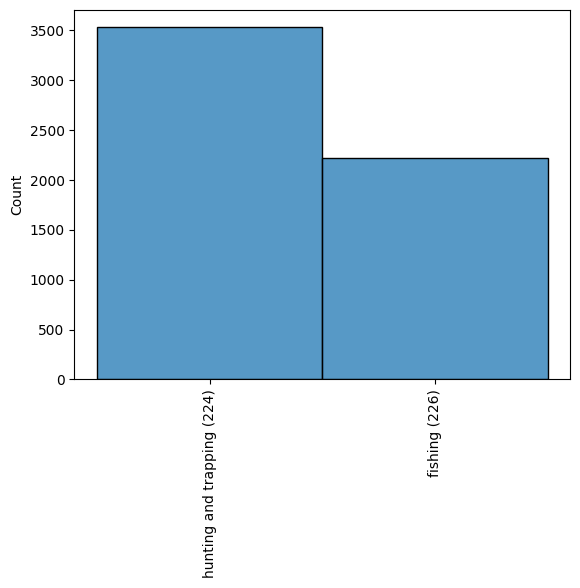

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## 0.9350724637681159
              precision    recall  f1-score   support

         224      0.913     0.990     0.950      1066
         226      0.981     0.847     0.909       659

    accuracy                          0.935      1725
   macro avg      0.947     0.918     0.929      1725
weighted avg      0.939     0.935     0.934      1725



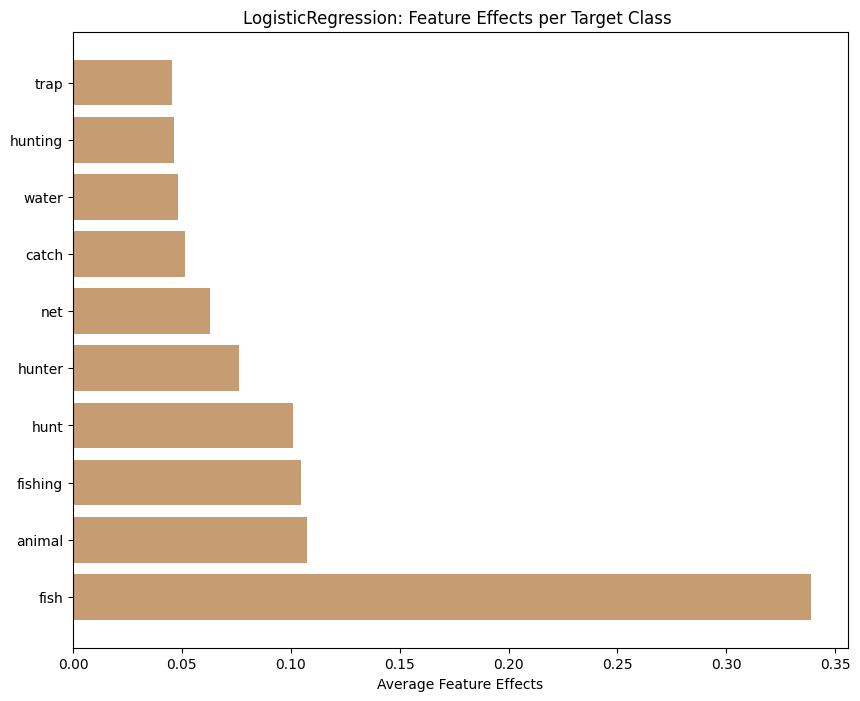

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.9391304347826087
              precision    recall  f1-score   support

         224      0.926     0.980     0.952      1066
         226      0.965     0.873     0.916       659

    accuracy                          0.939      1725
   macro avg      0.945     0.926     0.934      1725
weighted avg      0.941     0.939     0.938      1725



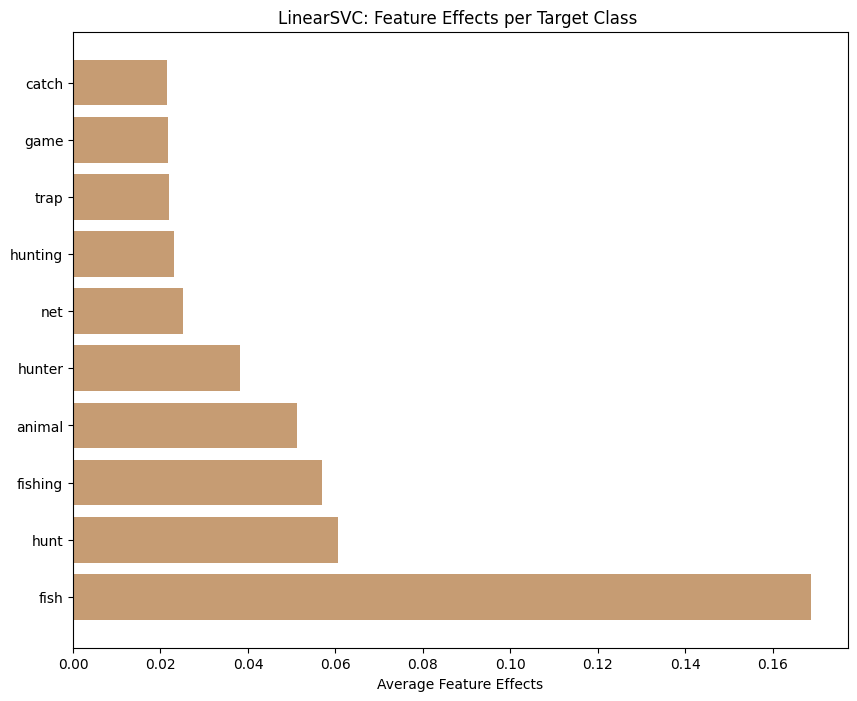

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.936231884057971
              precision    recall  f1-score   support

         224      0.919     0.983     0.950      1066
         226      0.969     0.860     0.912       659

    accuracy                          0.936      1725
   macro avg      0.944     0.922     0.931      1725
weighted avg      0.938     0.936     0.935      1725



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


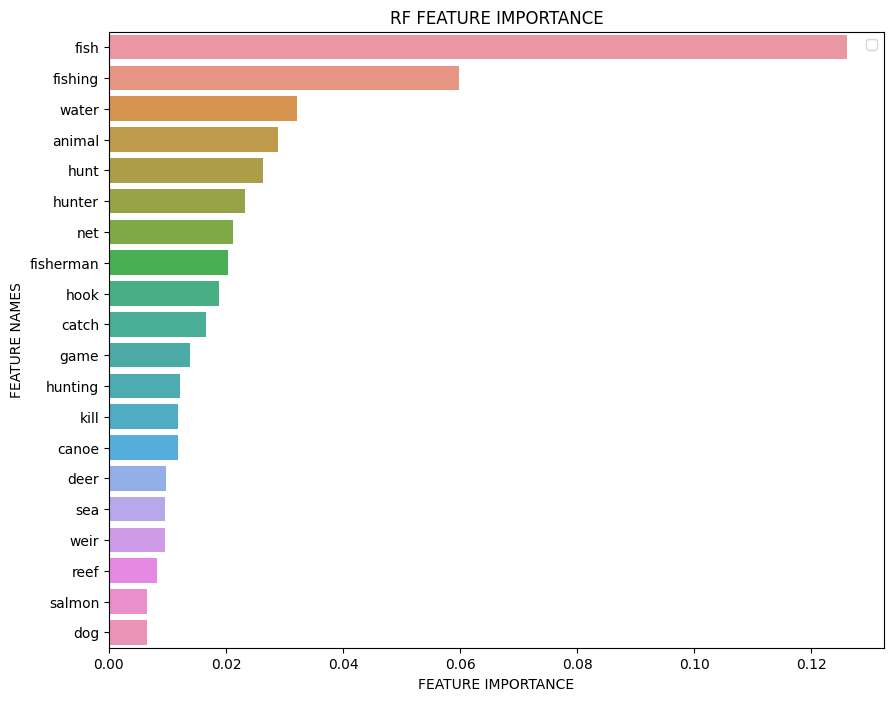

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 2
Exclude: {'trap', 'canoe', 'deer', 'fisherman', 'catch', 'salmon', 'game', 'water', 'hunting', 'hook', 'animal', 'sea', 'weir', 'net', 'hunt', 'kill', 'fish', 'reef', 'fishing', 'hunter', 'dog'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


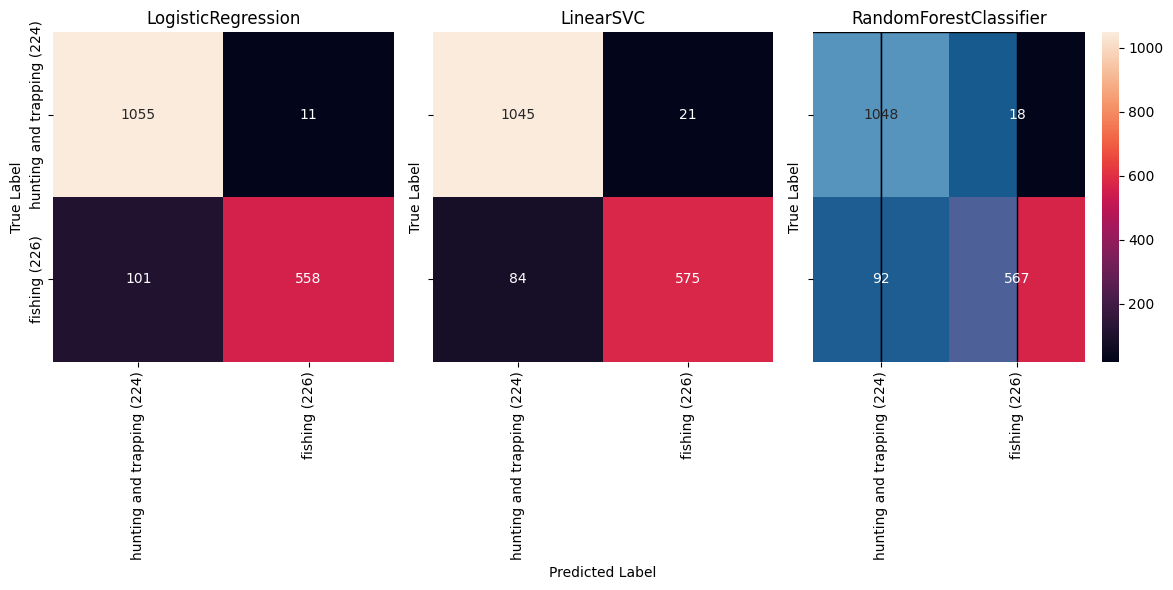

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8857971014492754
              precision    recall  f1-score   support

         224      0.866     0.964     0.913      1066
         226      0.929     0.759     0.835       659

    accuracy                          0.886      1725
   macro avg      0.898     0.862     0.874      1725
weighted avg      0.890     0.886     0.883      1725



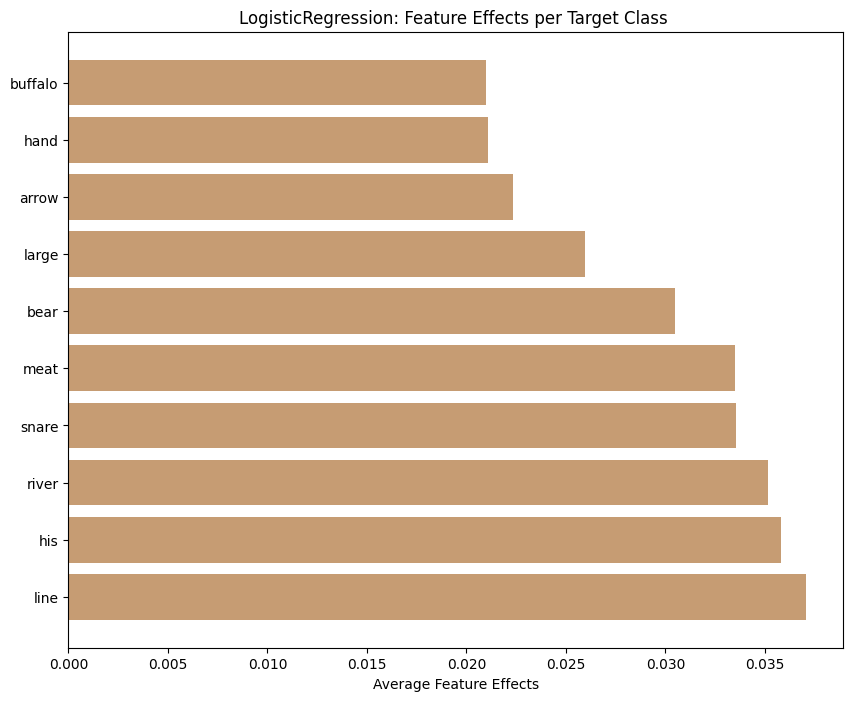

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8817391304347826
              precision    recall  f1-score   support

         224      0.877     0.940     0.908      1066
         226      0.890     0.788     0.836       659

    accuracy                          0.882      1725
   macro avg      0.884     0.864     0.872      1725
weighted avg      0.882     0.882     0.880      1725



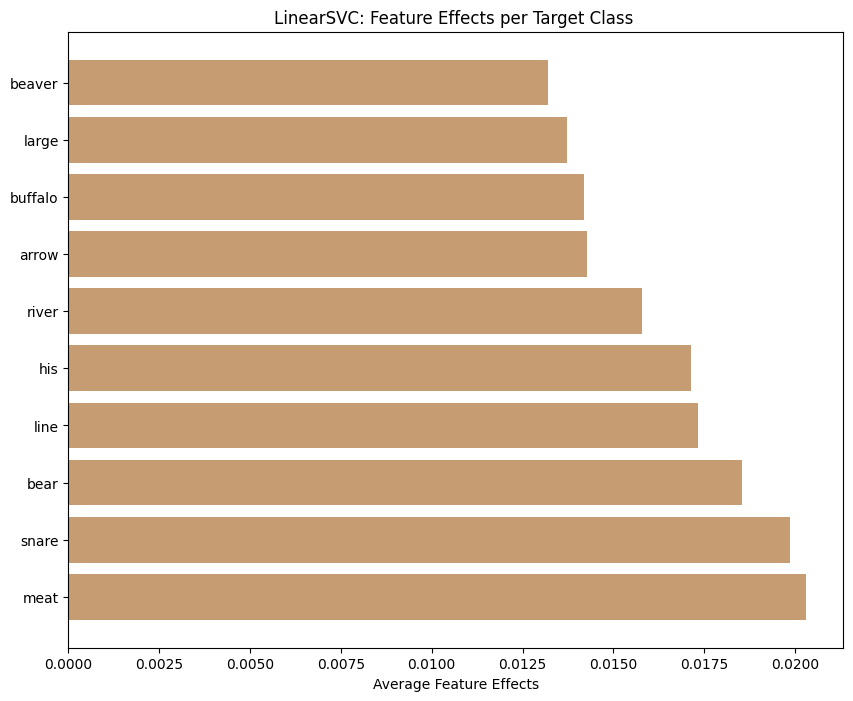

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8678260869565217
              precision    recall  f1-score   support

         224      0.856     0.946     0.898      1066
         226      0.894     0.742     0.811       659

    accuracy                          0.868      1725
   macro avg      0.875     0.844     0.855      1725
weighted avg      0.870     0.868     0.865      1725



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


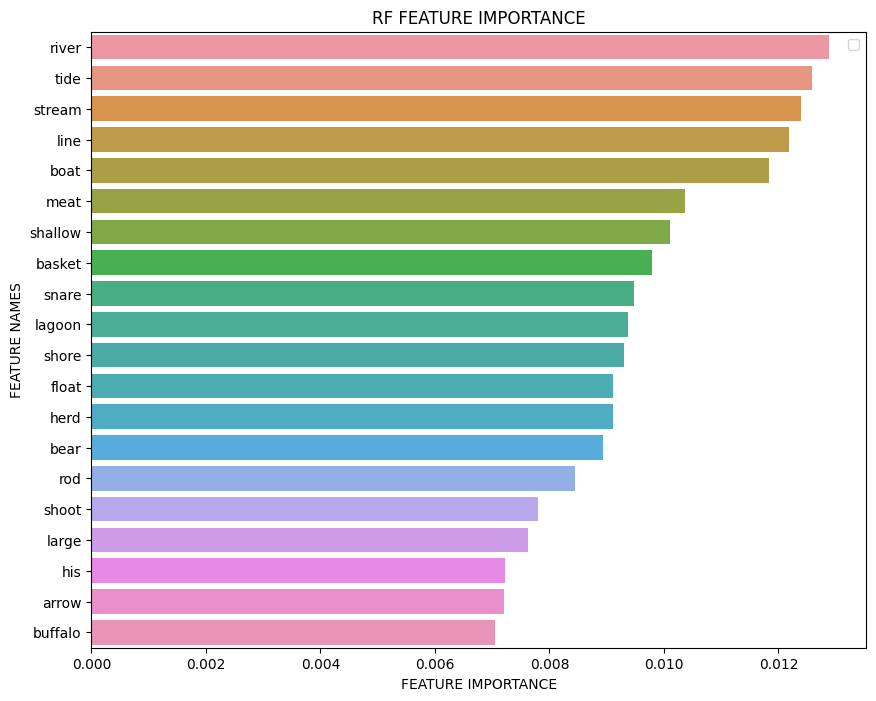

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 3
Exclude: {'river', 'line', 'tide', 'basket', 'salmon', 'meat', 'herd', 'rod', 'water', 'float', 'hunting', 'boat', 'beaver', 'large', 'animal', 'his', 'weir', 'net', 'fish', 'bear', 'snare', 'reef', 'fishing', 'hunter', 'dog', 'buffalo', 'trap', 'canoe', 'deer', 'fisherman', 'lagoon', 'catch', 'game', 'arrow', 'shallow', 'hand', 'hook', 'shoot', 'sea', 'hunt', 'kill', 'stream', 'shore'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


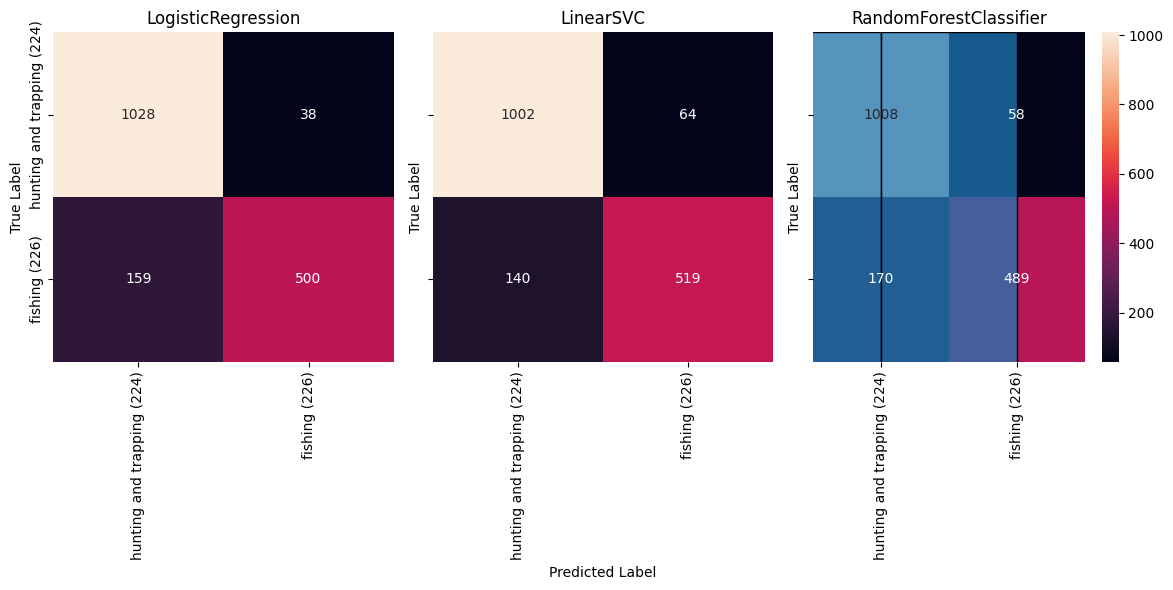

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8666666666666667
              precision    recall  f1-score   support

         224      0.848     0.956     0.899      1066
         226      0.910     0.722     0.805       659

    accuracy                          0.867      1725
   macro avg      0.879     0.839     0.852      1725
weighted avg      0.872     0.867     0.863      1725



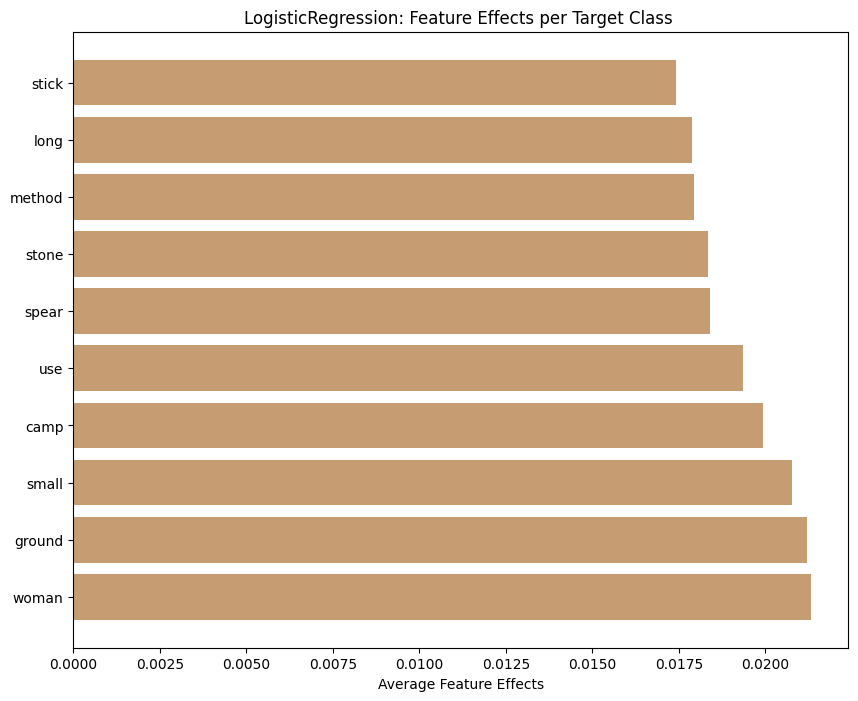

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8585507246376811
              precision    recall  f1-score   support

         224      0.864     0.915     0.889      1066
         226      0.848     0.768     0.806       659

    accuracy                          0.859      1725
   macro avg      0.856     0.841     0.847      1725
weighted avg      0.858     0.859     0.857      1725



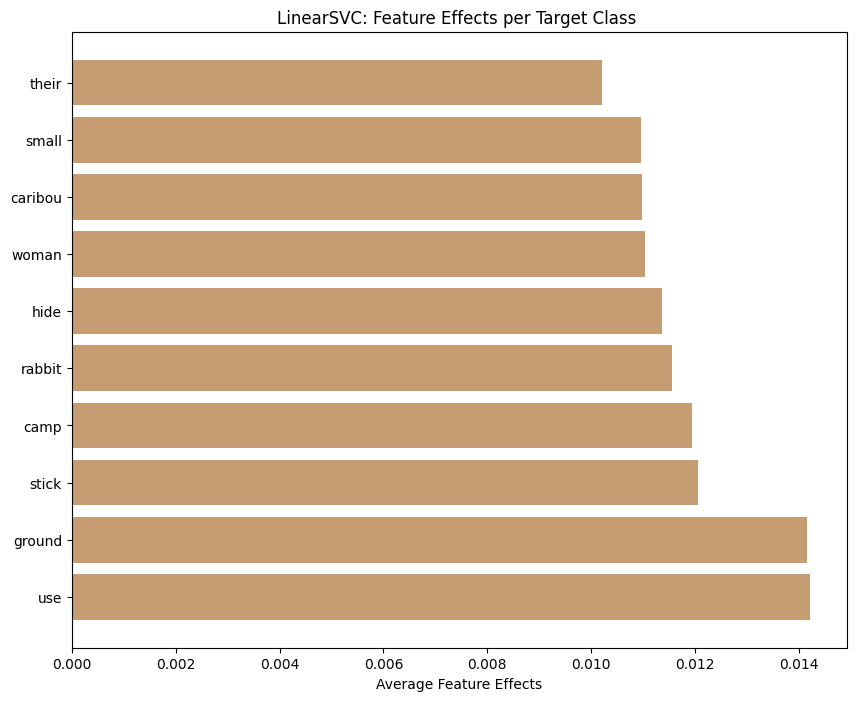

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8510144927536232
              precision    recall  f1-score   support

         224      0.840     0.937     0.886      1066
         226      0.875     0.712     0.785       659

    accuracy                          0.851      1725
   macro avg      0.858     0.824     0.835      1725
weighted avg      0.853     0.851     0.847      1725



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


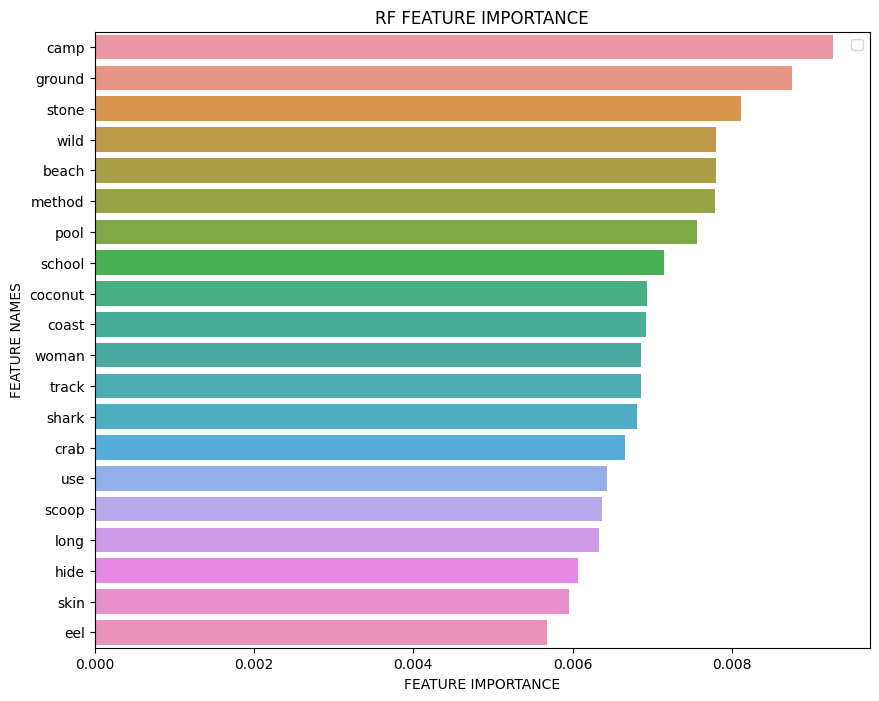

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



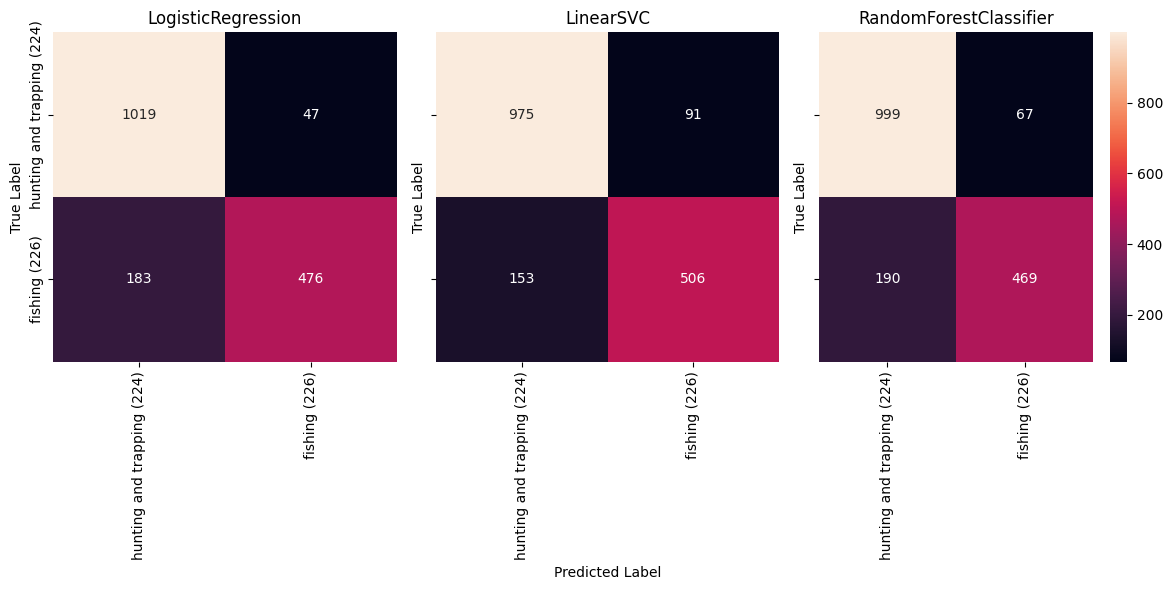

In [11]:
results = iterative_process(models=['LR', 'SVM', 'RF'], 
                            common_indicators=False,
                            chosen_categories=[224, 226],
                            # chosen_categories=[220, 221],
                            iterations=3,
                            # top_indicators={'fish', 'kill', 'beaver', 'reef', 'hunting', 'animal', 'deer', 'game', 'river', 'weir', 'fishing', 'canoe', 'sea', 'hook', 'net', 'hunter', 'salmon', 'fisherman', 'water', 'catch', 'hunt', 'line', 'herd', 'boat', 'buffalo', 'stream', 'basket', 'meat', 'snare', 'bear', 'dog'},
                            id='1 (224, 226)',
                            df_performance=df_performance,
                            balanced=False,
                            verbose=True)

In [12]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &    recall &  f1-score \\
\midrule
1 (224, 226)\_LR  &   0.946649 &  0.918209 &  0.929195 \\
1 (224, 226)\_SVM &   0.945181 &  0.926417 &  0.934249 \\
1 (224, 226)\_RF  &   0.944265 &  0.921754 &  0.930856 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_13264\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [13]:
plot_performance(results, fig_path='output/metric/224_226.png')



Balanced: True
Iteration 1
Exclude: set()

(16758,) (16758,)
16758 documents - 8.66MB (training set)
5 categories


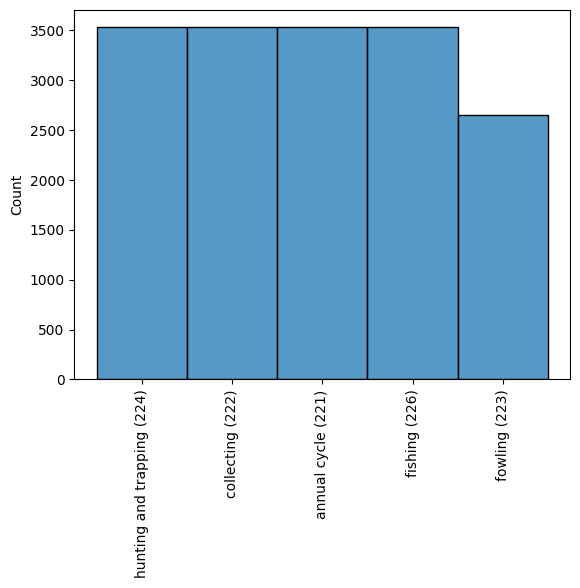

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7826173428798727
              precision    recall  f1-score   support

         221      0.801     0.734     0.766      1090
         222      0.593     0.879     0.708      1050
         223      0.922     0.681     0.783       793
         224      0.852     0.823     0.837      1035
         226      0.926     0.774     0.843      1060

    accuracy                          0.783      5028
   macro avg      0.819     0.778     0.787      5028
weighted avg      0.813     0.783     0.787      5028



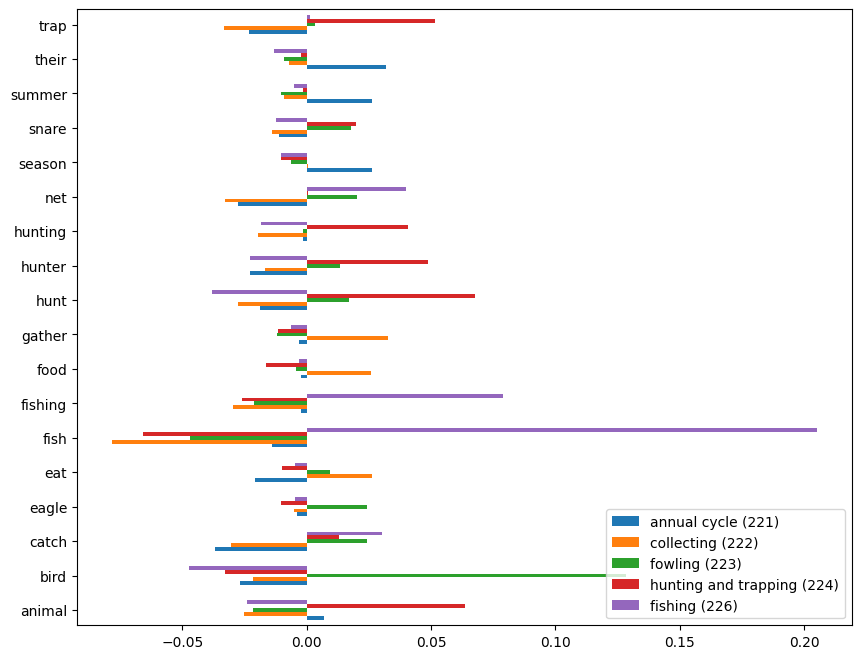

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7742641209228321
              precision    recall  f1-score   support

         221      0.815     0.710     0.759      1090
         222      0.591     0.867     0.703      1050
         223      0.858     0.696     0.769       793
         224      0.845     0.814     0.829      1035
         226      0.906     0.769     0.832      1060

    accuracy                          0.774      5028
   macro avg      0.803     0.771     0.778      5028
weighted avg      0.800     0.774     0.779      5028



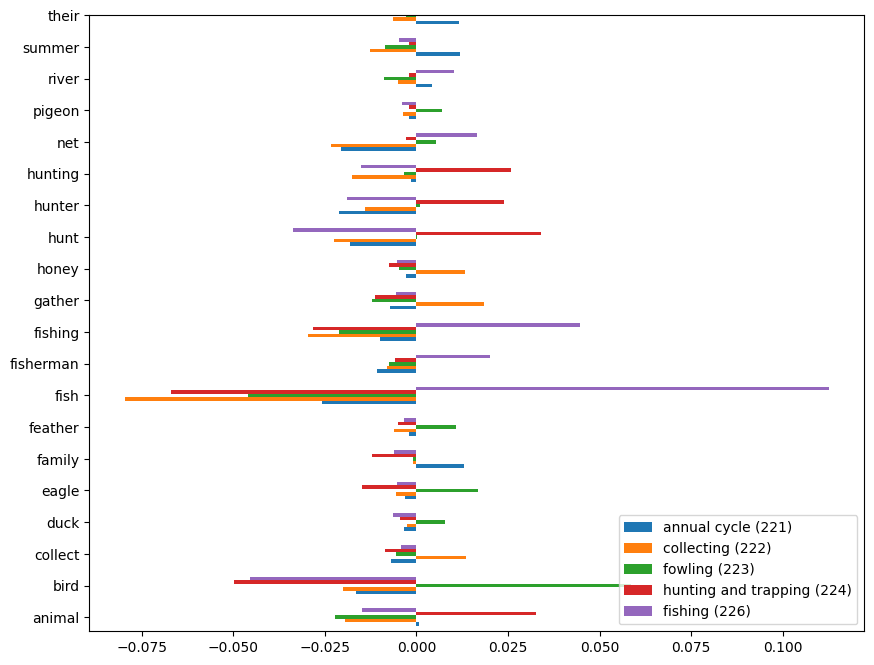

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.754574383452665
              precision    recall  f1-score   support

         221      0.793     0.694     0.740      1090
         222      0.579     0.847     0.688      1050
         223      0.913     0.622     0.740       793
         224      0.786     0.818     0.802      1035
         226      0.876     0.763     0.816      1060

    accuracy                          0.755      5028
   macro avg      0.790     0.749     0.757      5028
weighted avg      0.784     0.755     0.758      5028



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


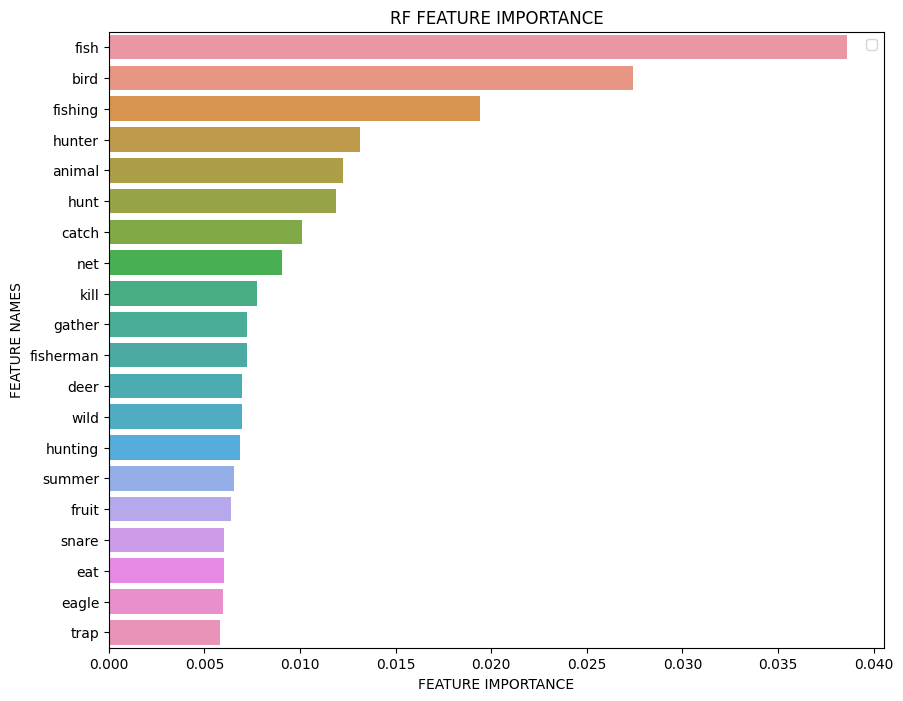

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



NameError: name 'curr_results' is not defined

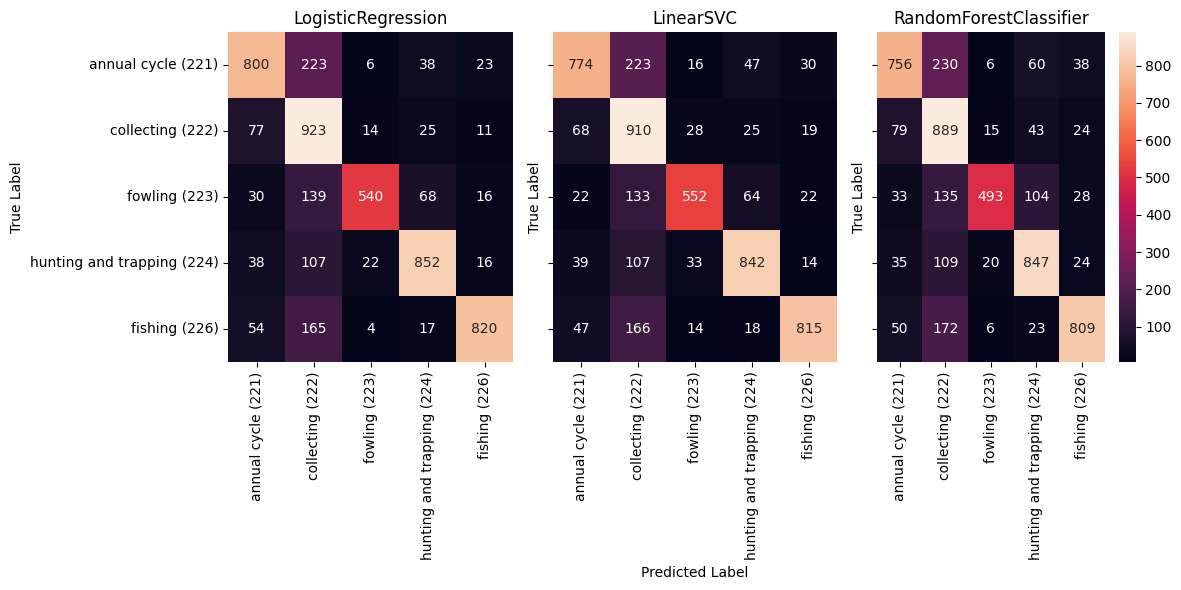

In [12]:
results = defaultdict(dict)
for b in [True, False]:
    print('\n\nBalanced:', b)
    results = iterative_process(models=['LR', 'SVM', 'RF'], 
                            common_indicators=False,
                            chosen_categories=[221, 222, 223, 224, 226],
                            # chosen_categories=[220, 221],
                            iterations=1,
                            id='1 (221..226)',
                            df_performance=df_performance,
                            balanced=b,
                            verbose=True)
    results[f'{i}_{"balanced" if b else "imbalanced"}'] = curr_results
    

In [13]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &    recall &  f1-score \\
\midrule
test (224, 226)\_LR  &   0.440828 &  0.500000 &  0.468553 \\
test (224, 226)\_SVM &   0.946108 &  0.550000 &  0.562428 \\
1 (221..226)\_LR     &   0.818523 &  0.778145 &  0.787457 \\
1 (221..226)\_SVM    &   0.803089 &  0.771049 &  0.778276 \\
1 (221..226)\_RF     &   0.789667 &  0.748700 &  0.757121 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_14488\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [16]:

for b in [True, False]:
    print('\n\nBalanced:', b)
    plot_performance(results[f'{i}_{"balanced" if b else "imbalanced"}'], fig_path=f'output/metric/221..226_{"balanced" if b else "imbalanced"}.png')

### 241 and 243

for b in [True, False]:
    print('\n\nBalanced:', b)
    results = iterative_process(common_indicators=False,
                            models=['LR', 'SVM', 'RF'], 
                            chosen_categories=[241, 243], 
                            balanced=b,
                            verbose=True)

In [17]:
# results = iterative_process(common_indicators=False,
#                         models=['LR', 'SVM', 'RF'], 
#                         chosen_categories=[241, 243],
#                         id='1 (241, 243)',
#                         df_performance=df_performance,
#                         balanced=False,
#                         verbose=True)

In [18]:
# plot_performance(results, fig_path='output/metric/241_243.png')

# Cat vs subcategories (binary classification)

results = defaultdict(dict)
for b in [True, False]:
    print('\n\nBalanced:', b)
    
    for i in [224, 226, 241, 243]:
        curr_results = iterative_process(common_indicators=False,
                                    models=['LR', 'SVM', 'RF'], 
                                    specific_cat=i, exact=True, 
                                    balanced=b,
                                    verbose=True)
        results[f'i_{"balanced" if b else "imbalanced"}'] = curr_results

### 224, 226 and rest of 220

Iteration 1
Exclude: set()



C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(10378,) (10378,)
10378 documents - 4.92MB (training set)
2 categories


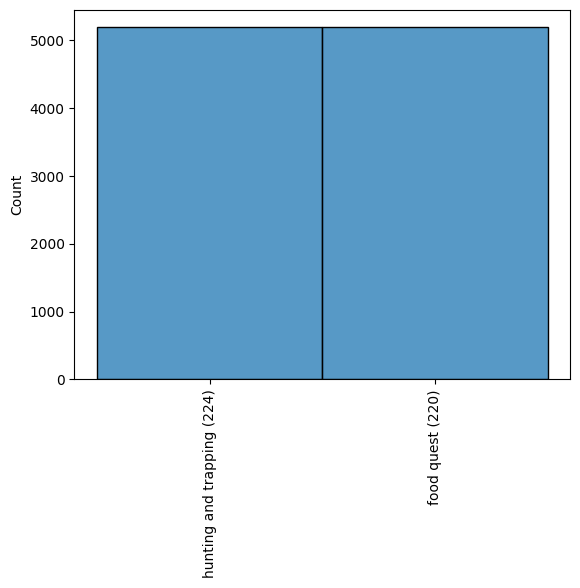

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8696210661528581
              precision    recall  f1-score   support

         220      0.846     0.906     0.875      1572
         224      0.897     0.832     0.863      1542

    accuracy                          0.870      3114
   macro avg      0.872     0.869     0.869      3114
weighted avg      0.871     0.870     0.869      3114



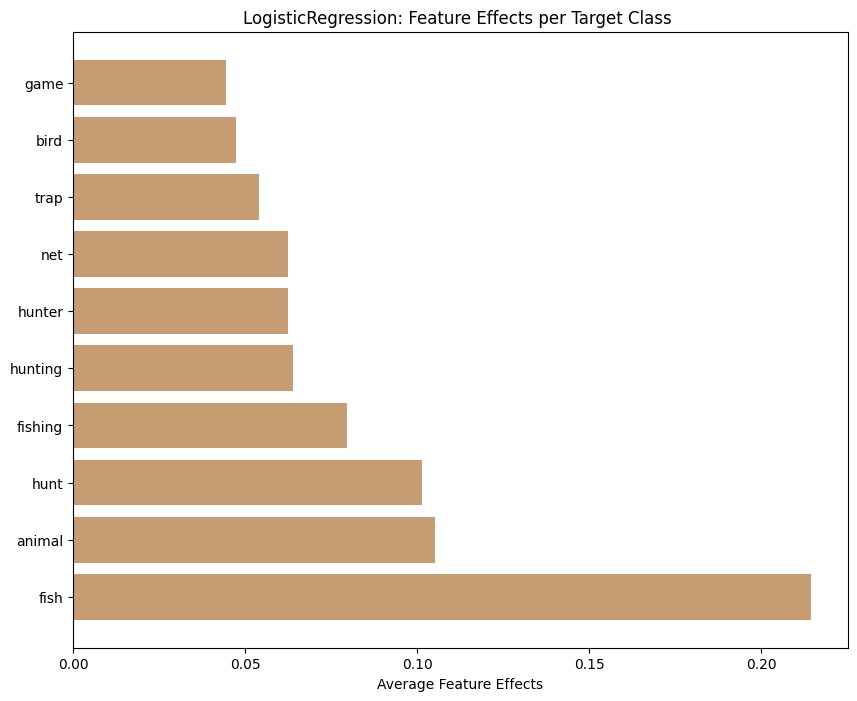

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8648041104688503
              precision    recall  f1-score   support

         220      0.838     0.908     0.872      1572
         224      0.898     0.820     0.857      1542

    accuracy                          0.865      3114
   macro avg      0.868     0.864     0.864      3114
weighted avg      0.867     0.865     0.865      3114



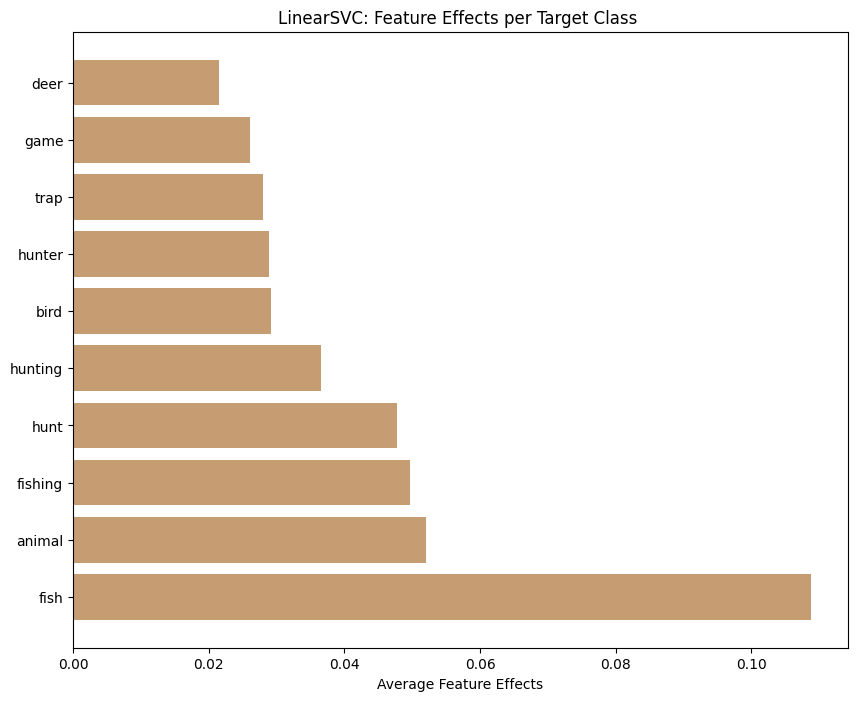

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8432883750802826
              precision    recall  f1-score   support

         220      0.909     0.767     0.832      1572
         224      0.795     0.922     0.853      1542

    accuracy                          0.843      3114
   macro avg      0.852     0.844     0.843      3114
weighted avg      0.852     0.843     0.842      3114



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


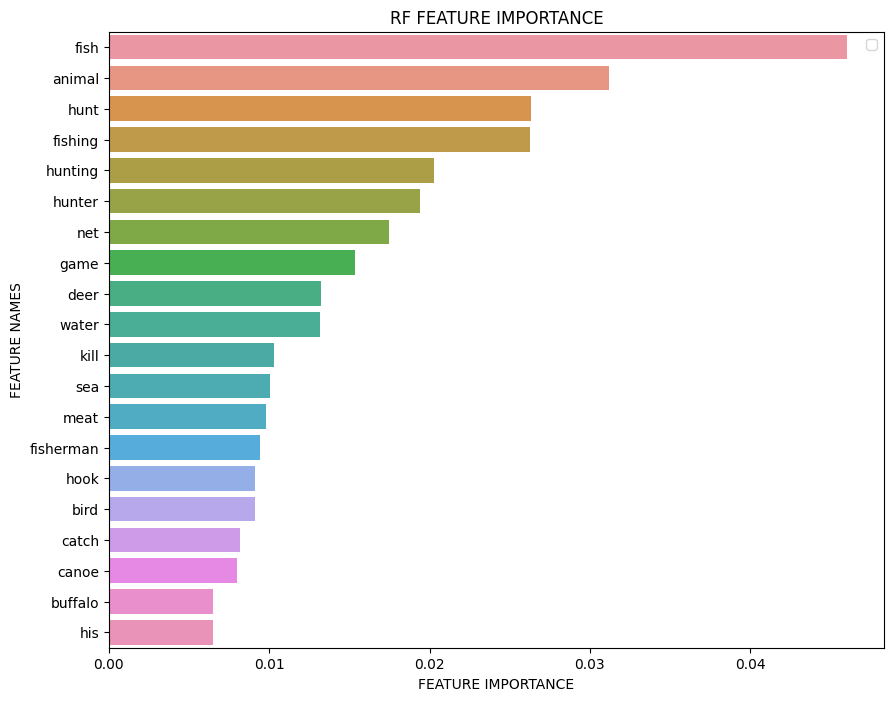

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 1
Exclude: set()



C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(12990,) (12990,)
12990 documents - 6.34MB (training set)
2 categories


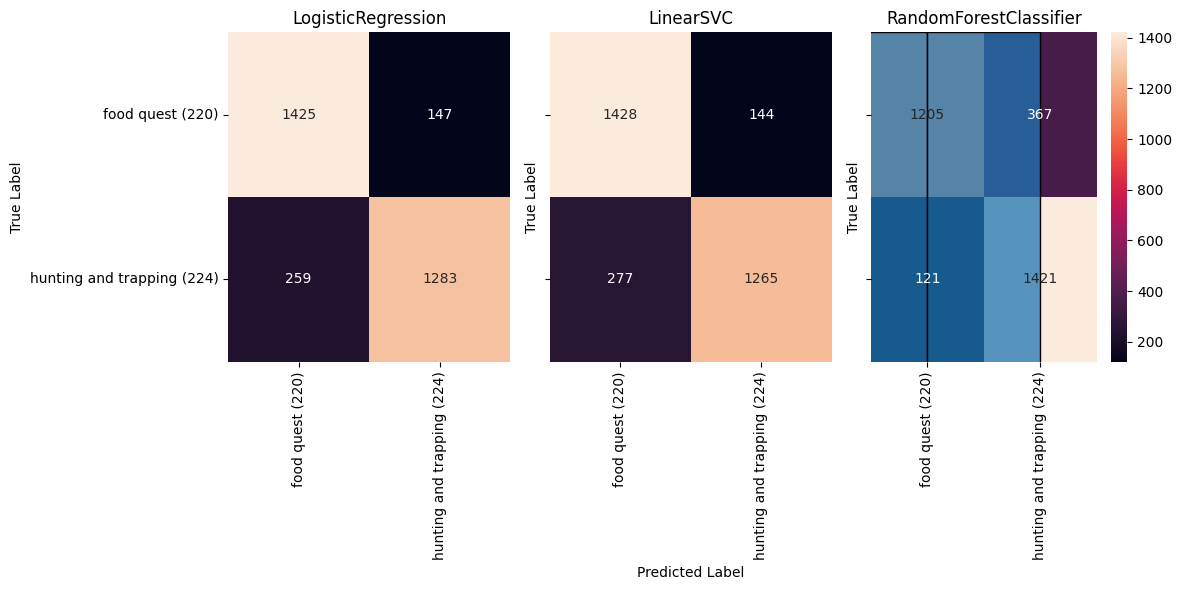

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8519373877341545
              precision    recall  f1-score   support

         220      0.917     0.777     0.841      1967
         226      0.803     0.928     0.861      1930

    accuracy                          0.852      3897
   macro avg      0.860     0.853     0.851      3897
weighted avg      0.861     0.852     0.851      3897



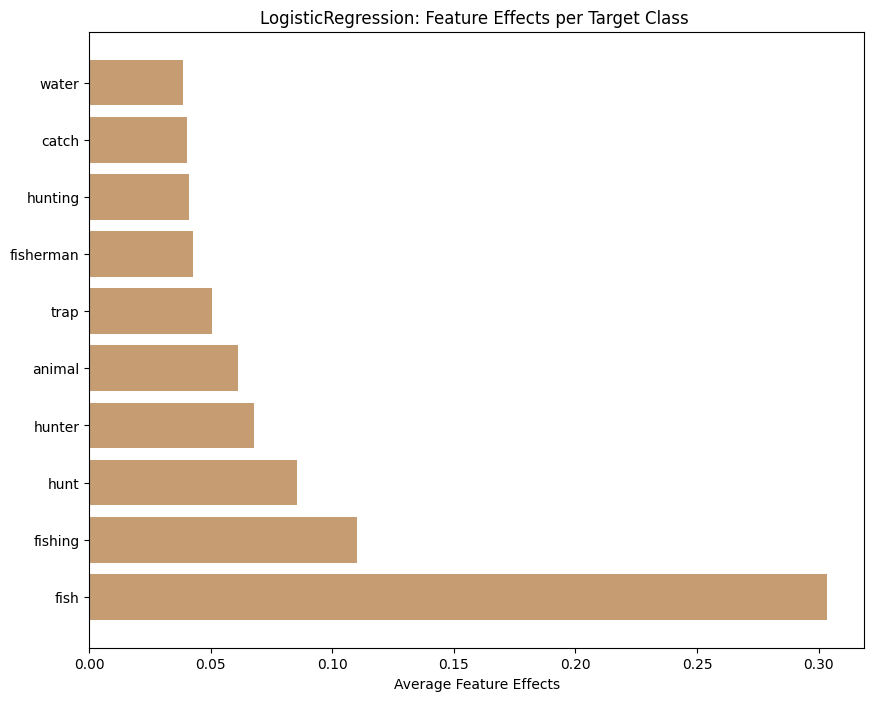

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8357711059789582
              precision    recall  f1-score   support

         220      0.893     0.767     0.825      1967
         226      0.792     0.906     0.845      1930

    accuracy                          0.836      3897
   macro avg      0.842     0.836     0.835      3897
weighted avg      0.843     0.836     0.835      3897



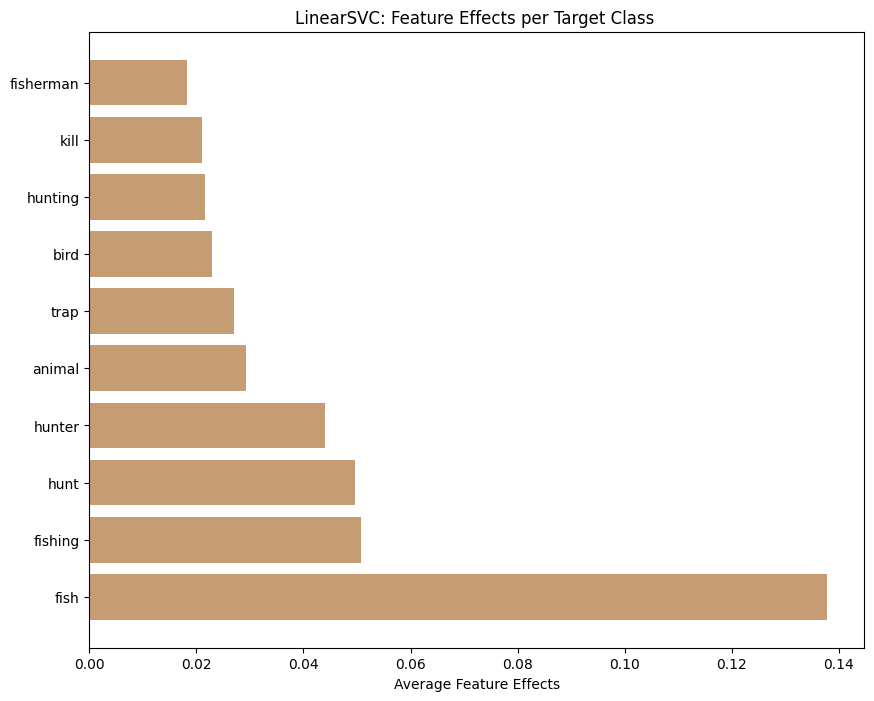

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8452655889145496
              precision    recall  f1-score   support

         220      0.914     0.766     0.833      1967
         226      0.795     0.926     0.856      1930

    accuracy                          0.845      3897
   macro avg      0.854     0.846     0.844      3897
weighted avg      0.855     0.845     0.844      3897



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


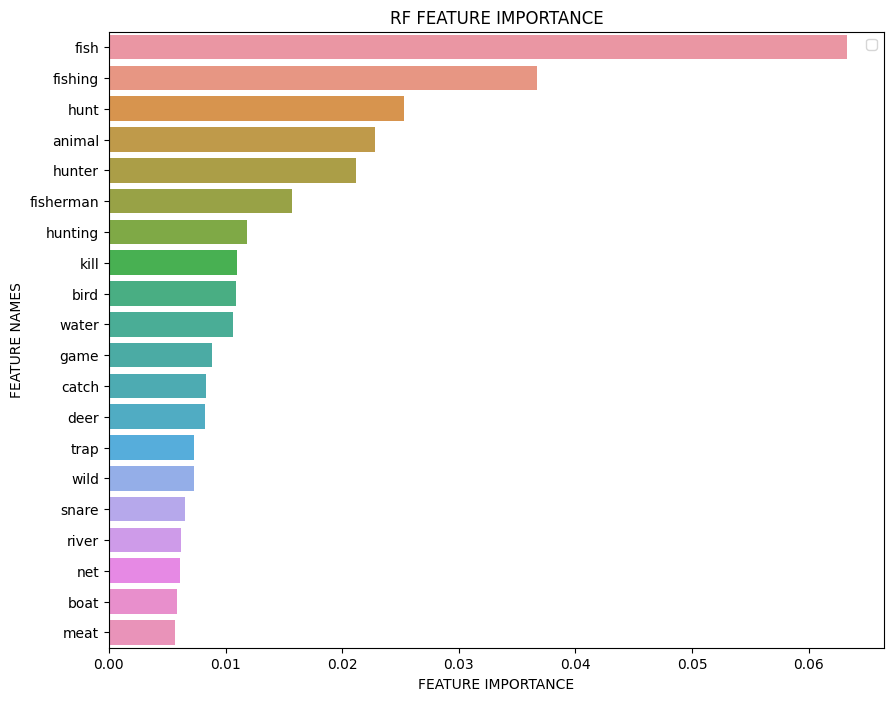

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



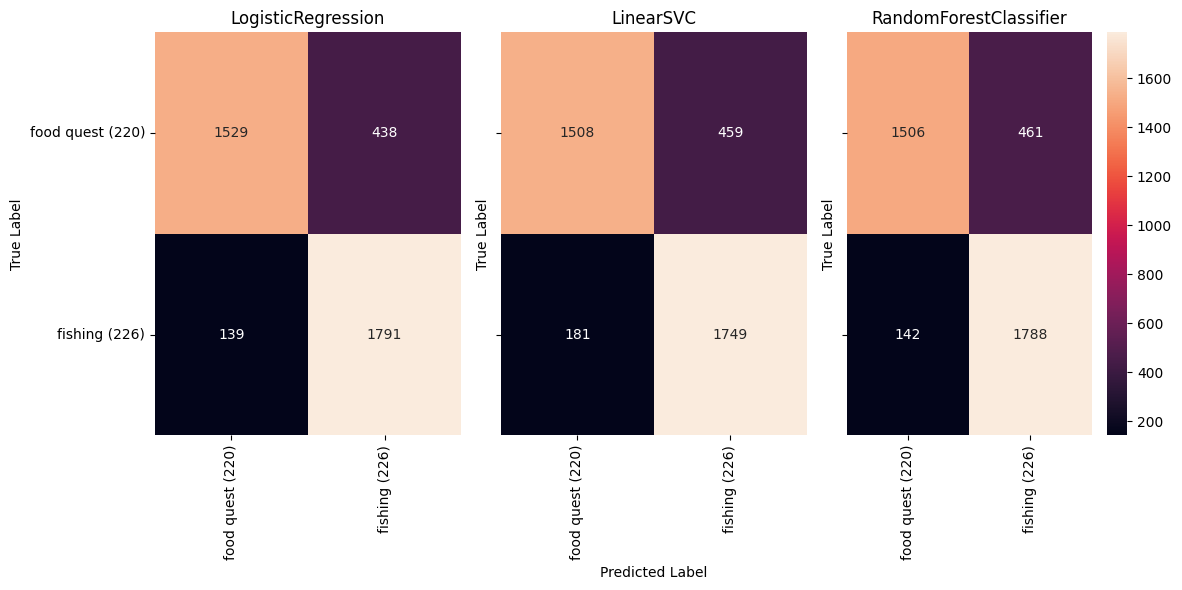

In [14]:
results = defaultdict(dict)
for i in [224, 226]:#, 241, 243]:
    curr_results = iterative_process(common_indicators=False,
                                models=['LR', 'SVM', 'RF'], 
                                specific_cat=i, exact=True, 
                                id=f'2 ({i})',
                                df_performance=df_performance,
                                iterations=1,
                                balanced=True,
                                verbose=True)
    results[i] = curr_results

In [ ]:

# for b in [True, False]:
#     print('\n\nBalanced:', b)
for i in [224, 226]:#, 241, 243]:
    plot_performance(results[i], fig_path=f'output/metric/{i}_220.png')

In [16]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &    recall &  f1-score \\
\midrule
2 (224)\_LR  &   0.871701 &  0.869262 &  0.869349 \\
2 (224)\_SVM &   0.867668 &  0.864380 &  0.864433 \\
2 (224)\_RF  &   0.851745 &  0.844035 &  0.842531 \\
2 (226)\_LR  &   0.860083 &  0.852653 &  0.851265 \\
2 (226)\_SVM &   0.842478 &  0.836434 &  0.835141 \\
2 (226)\_RF  &   0.854427 &  0.846029 &  0.844451 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_22824\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



# Cat vs subcategories (multi-class classification)



Balanced: True
Iteration 1
Exclude: set()

(25545,) (25545,)
25545 documents - 13.73MB (training set)
9 categories


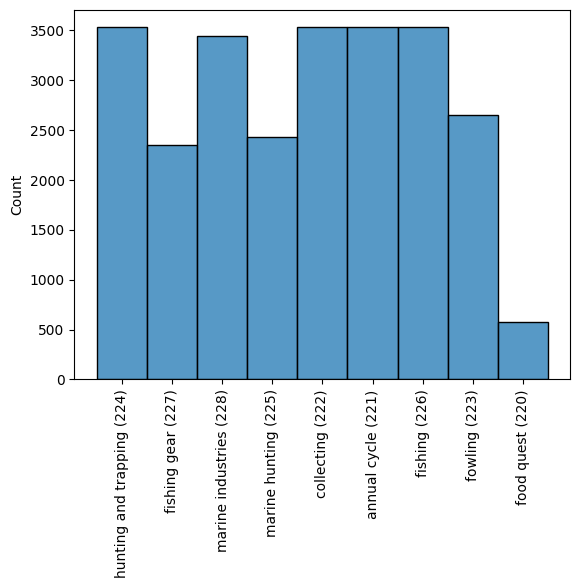

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7034185803757829
              precision    recall  f1-score   support

         220      0.909     0.108     0.193       185
         221      0.740     0.710     0.724      1096
         222      0.465     0.873     0.607      1016
         223      0.891     0.652     0.753       799
         224      0.802     0.809     0.806      1050
         225      0.866     0.728     0.791       684
         226      0.708     0.594     0.646      1084
         227      0.695     0.487     0.573       716
         228      0.802     0.817     0.809      1034

    accuracy                          0.703      7664
   macro avg      0.764     0.642     0.656      7664
weighted avg      0.743     0.703     0.702      7664



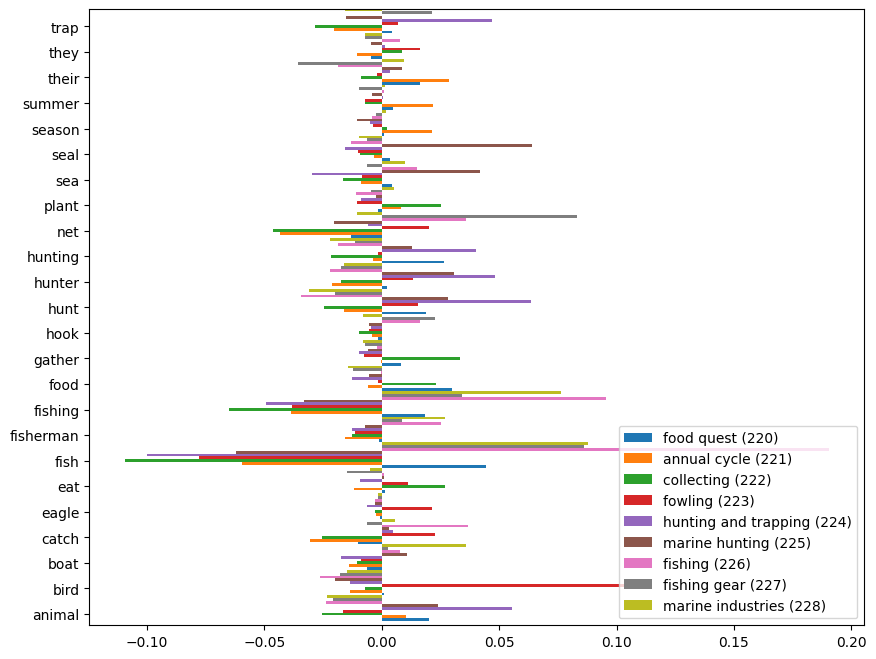

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7013308977035491
              precision    recall  f1-score   support

         220      0.636     0.227     0.335       185
         221      0.765     0.669     0.714      1096
         222      0.474     0.867     0.613      1016
         223      0.850     0.661     0.744       799
         224      0.808     0.788     0.798      1050
         225      0.825     0.756     0.789       684
         226      0.682     0.601     0.639      1084
         227      0.675     0.496     0.572       716
         228      0.818     0.812     0.815      1034

    accuracy                          0.701      7664
   macro avg      0.726     0.653     0.669      7664
weighted avg      0.730     0.701     0.702      7664



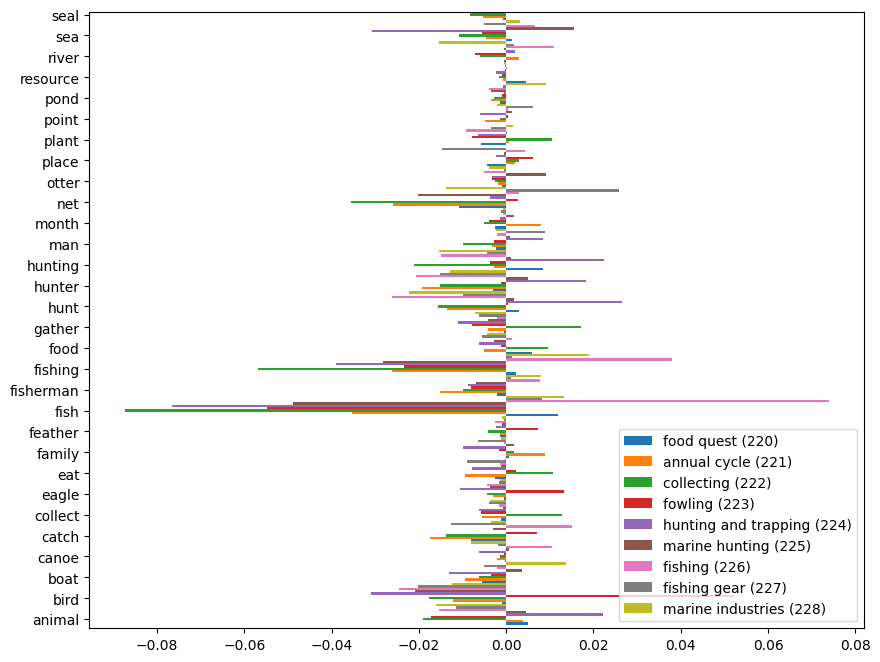

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6606210855949896
              precision    recall  f1-score   support

         220      1.000     0.027     0.053       185
         221      0.712     0.654     0.682      1096
         222      0.446     0.847     0.584      1016
         223      0.881     0.612     0.722       799
         224      0.727     0.793     0.759      1050
         225      0.805     0.675     0.734       684
         226      0.624     0.592     0.608      1084
         227      0.683     0.398     0.503       716
         228      0.769     0.744     0.756      1034

    accuracy                          0.661      7664
   macro avg      0.739     0.594     0.600      7664
weighted avg      0.704     0.661     0.656      7664



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


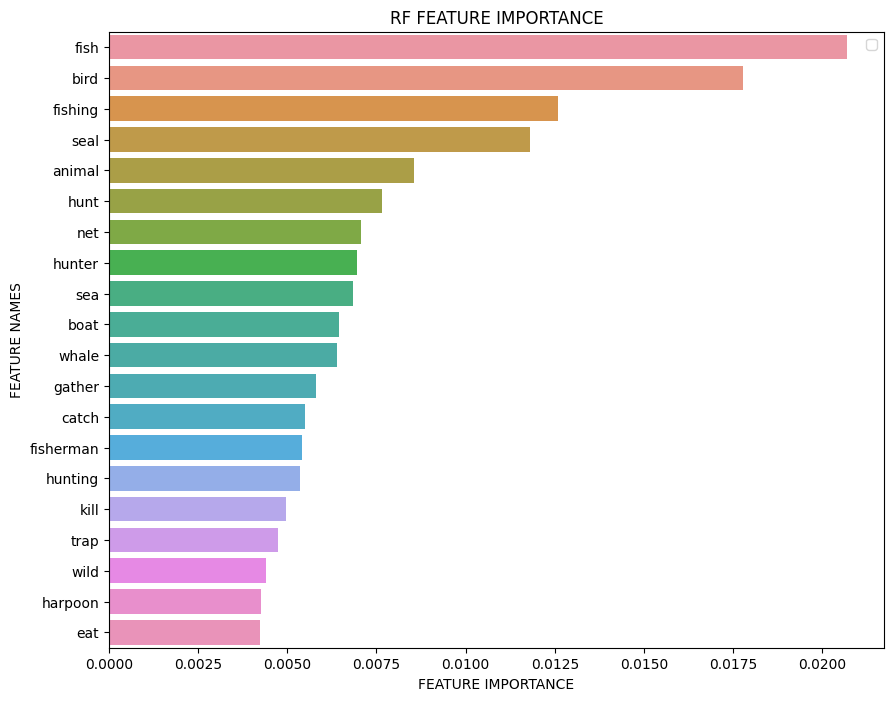

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 2
Exclude: {'river', 'wild', 'time', 'resource', 'otter', 'eagle', 'water', 'boat', 'place', 'hunting', 'seal', 'summer', 'eat', 'harpoon', 'pond', 'animal', 'gather', 'family', 'net', 'season', 'fish', 'their', 'fishing', 'winter', 'hunter', 'trap', 'canoe', 'tree', 'man', 'fisherman', 'point', 'catch', 'feather', 'year', 'hook', 'work', 'sea', 'they', 'bird', 'collect', 'month', 'hunt', 'plant', 'whale', 'kill', 'turtle', 'food'}

(25545,) (25545,)
25545 documents - 13.73MB (training set)
9 categories


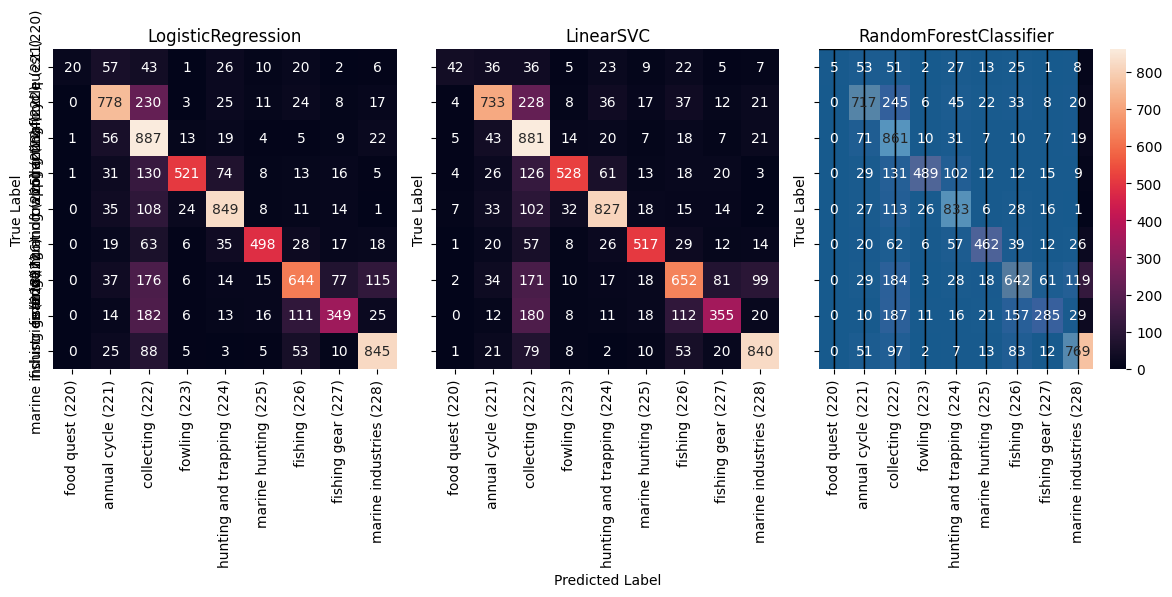

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6443110647181628
              precision    recall  f1-score   support

         220      1.000     0.032     0.063       185
         221      0.682     0.657     0.669      1096
         222      0.447     0.840     0.583      1016
         223      0.793     0.571     0.664       799
         224      0.736     0.720     0.728      1050
         225      0.716     0.624     0.667       684
         226      0.616     0.527     0.568      1084
         227      0.659     0.440     0.528       716
         228      0.764     0.807     0.785      1034

    accuracy                          0.644      7664
   macro avg      0.713     0.580     0.584      7664
weighted avg      0.680     0.644     0.639      7664



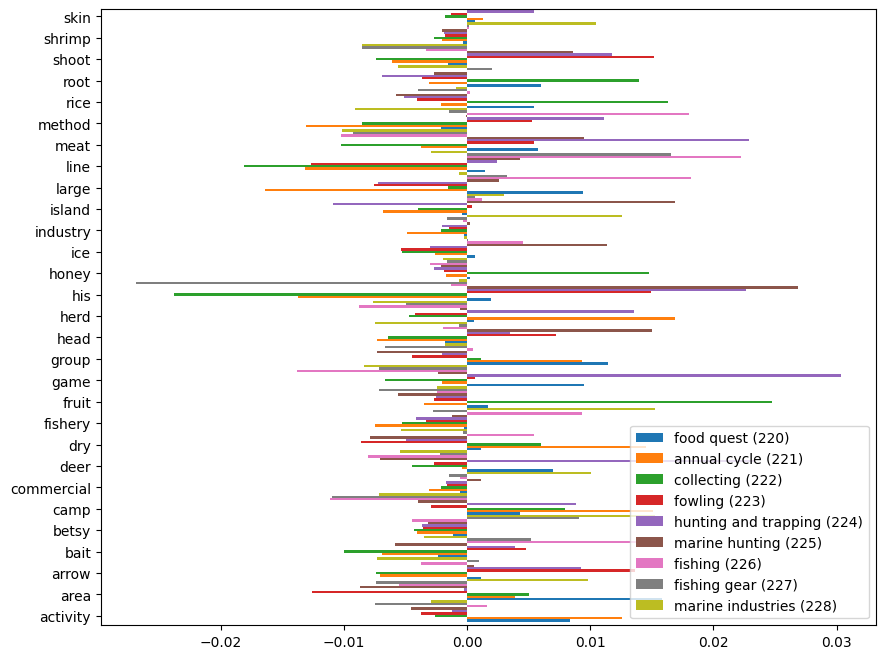

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.639874739039666
              precision    recall  f1-score   support

         220      0.577     0.162     0.253       185
         221      0.713     0.635     0.672      1096
         222      0.445     0.815     0.576      1016
         223      0.759     0.586     0.661       799
         224      0.728     0.710     0.718      1050
         225      0.679     0.643     0.661       684
         226      0.609     0.504     0.551      1084
         227      0.619     0.457     0.526       716
         228      0.776     0.797     0.786      1034

    accuracy                          0.640      7664
   macro avg      0.656     0.590     0.600      7664
weighted avg      0.663     0.640     0.638      7664



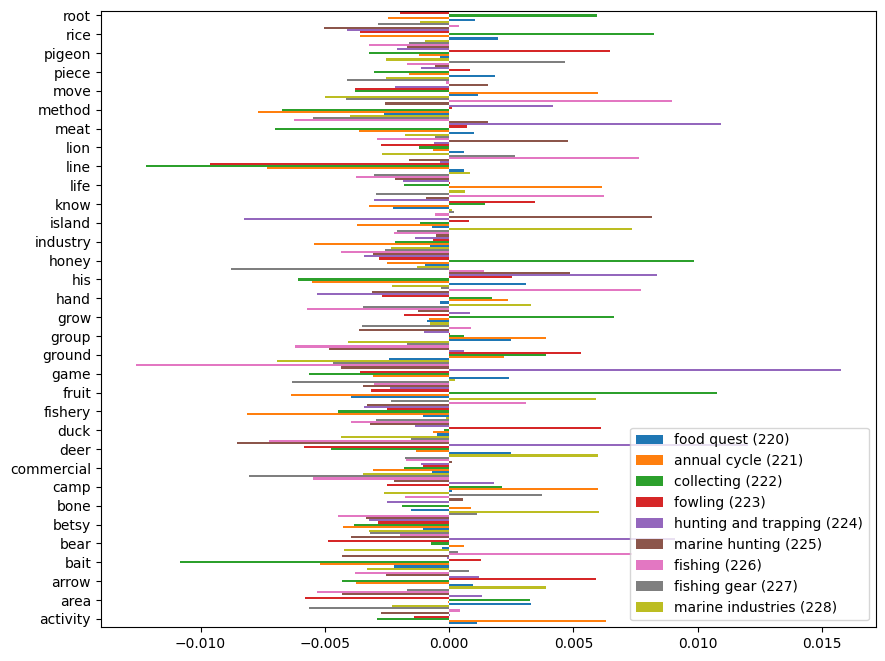

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.5808977035490606
              precision    recall  f1-score   support

         220      1.000     0.011     0.021       185
         221      0.646     0.581     0.612      1096
         222      0.407     0.780     0.535      1016
         223      0.739     0.488     0.588       799
         224      0.637     0.694     0.665      1050
         225      0.655     0.522     0.581       684
         226      0.538     0.447     0.489      1084
         227      0.600     0.381     0.466       716
         228      0.679     0.761     0.718      1034

    accuracy                          0.581      7664
   macro avg      0.656     0.518     0.519      7664
weighted avg      0.617     0.581     0.573      7664



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


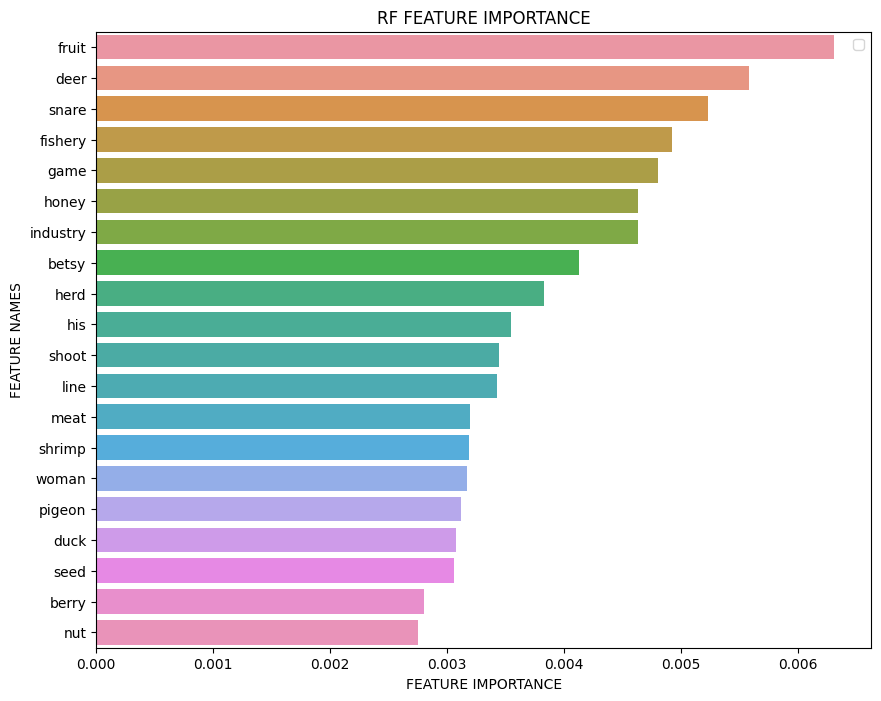

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 3
Exclude: {'river', 'line', 'use', 'fishery', 'time', 'herd', 'eagle', 'place', 'summer', 'large', 'method', 'eat', 'harpoon', 'pond', 'pigeon', 'animal', 'gather', 'bone', 'village', 'duck', 'dry', 'piece', 'camp', 'bear', 'ground', 'snare', 'woman', 'winter', 'hunter', 'trap', 'activity', 'deer', 'man', 'berry', 'arrow', 'subsistence', 'seed', 'year', 'shoot', 'betsy', 'group', 'lion', 'turtle', 'season', 'food', 'wild', 'ice', 'rice', 'size', 'resource', 'area', 'otter', 'meat', 'water', 'boat', 'hunting', 'seal', 'nut', 'spear', 'his', 'honey', 'family', 'net', 'bait', 'fish', 'life', 'their', 'fishing', 'know', 'canoe', 'stick', 'tree', 'fisherman', 'point', 'catch', 'type', 'island', 'game', 'feather', 'shell', 'hand', 'shrimp', 'hook', 'grow', 'move', 'work', 'commercial', 'sea', 'they', 'bird', 'collect', 'root', 'small', 'month', 'hunt', 'plant', 'whale', 'kill', 'fruit', 'skin', 'head', 'industry'}

(25545,) (25545,)
25545 documents - 13.73MB (training set)
9 categ

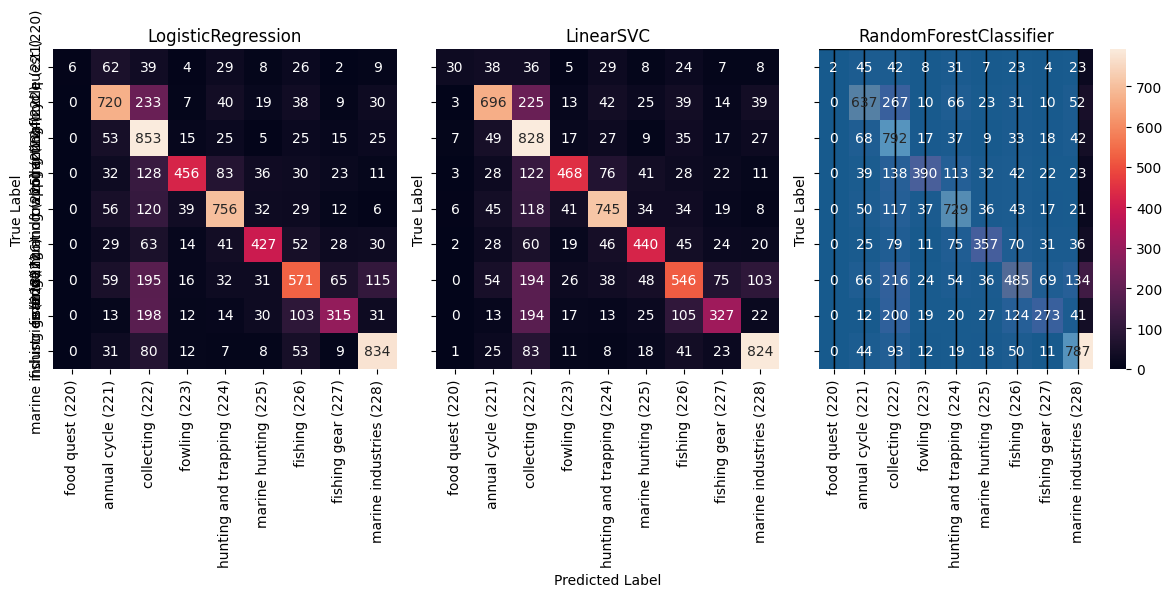

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.62330375782881
              precision    recall  f1-score   support

         220      1.000     0.027     0.053       185
         221      0.680     0.656     0.668      1096
         222      0.421     0.796     0.551      1016
         223      0.757     0.539     0.630       799
         224      0.701     0.685     0.693      1050
         225      0.728     0.598     0.657       684
         226      0.589     0.506     0.545      1084
         227      0.654     0.433     0.521       716
         228      0.738     0.799     0.767      1034

    accuracy                          0.623      7664
   macro avg      0.697     0.560     0.565      7664
weighted avg      0.661     0.623     0.618      7664



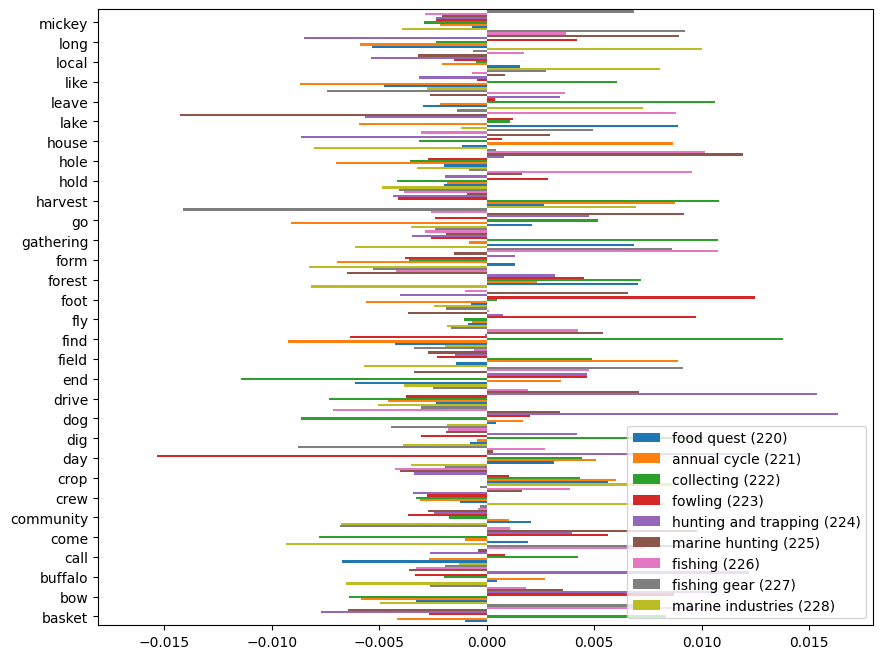

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6163883089770354
              precision    recall  f1-score   support

         220      0.403     0.135     0.202       185
         221      0.691     0.615     0.651      1096
         222      0.427     0.783     0.553      1016
         223      0.705     0.563     0.626       799
         224      0.698     0.659     0.678      1050
         225      0.657     0.626     0.641       684
         226      0.594     0.484     0.534      1084
         227      0.612     0.459     0.525       716
         228      0.759     0.779     0.769      1034

    accuracy                          0.616      7664
   macro avg      0.616     0.567     0.575      7664
weighted avg      0.637     0.616     0.615      7664



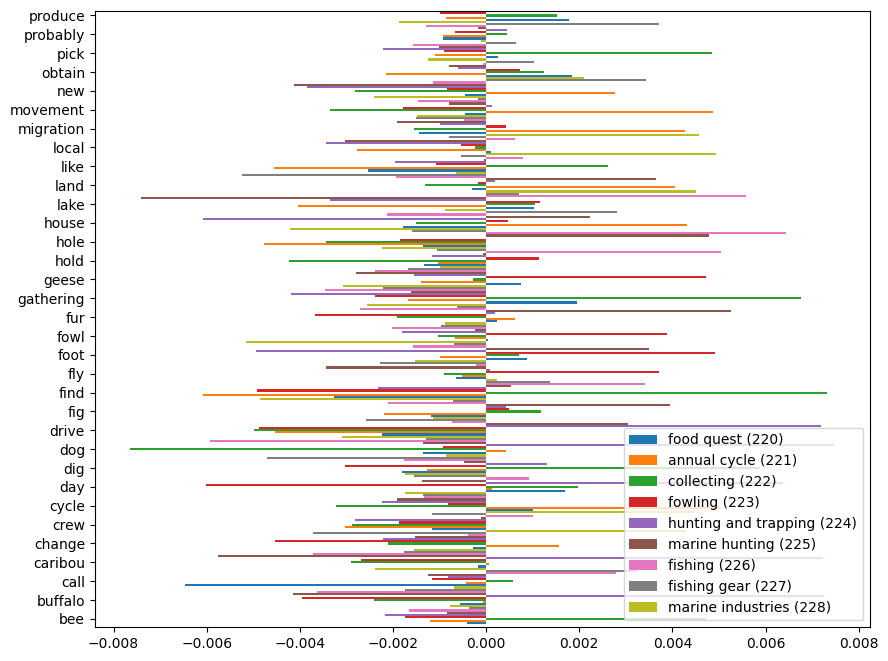

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.5540187891440501
              precision    recall  f1-score   support

         220      1.000     0.005     0.011       185
         221      0.636     0.569     0.601      1096
         222      0.390     0.747     0.512      1016
         223      0.689     0.444     0.540       799
         224      0.594     0.645     0.619      1050
         225      0.713     0.468     0.565       684
         226      0.517     0.426     0.467      1084
         227      0.586     0.387     0.466       716
         228      0.609     0.746     0.671      1034

    accuracy                          0.554      7664
   macro avg      0.637     0.493     0.495      7664
weighted avg      0.594     0.554     0.546      7664



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


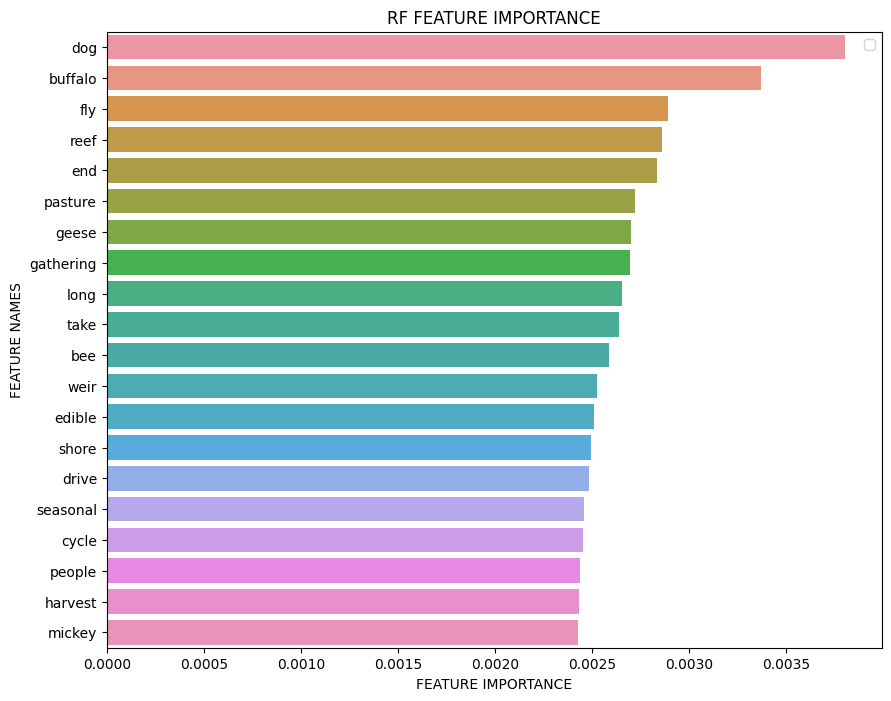

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.





Balanced: False
Iteration 1
Exclude: set()

(8717,) (8717,)
8717 documents - 3.86MB (training set)
9 categories


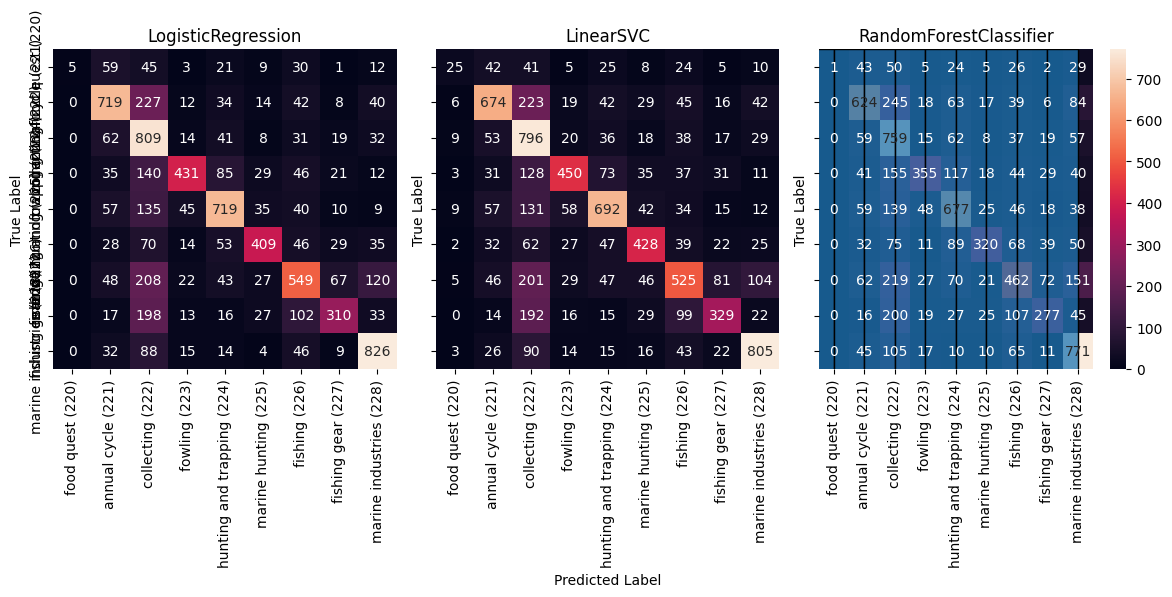

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7584097859327217
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.817     0.531     0.644       143
         222      0.870     0.545     0.670       123
         223      0.922     0.562     0.698       210
         224      0.737     0.968     0.836      1081
         225      0.934     0.483     0.637       118
         226      0.742     0.834     0.786       650
         227      0.729     0.340     0.464       206
         228      0.727     0.119     0.205        67

    accuracy                          0.758      2616
   macro avg      0.720     0.487     0.549      2616
weighted avg      0.767     0.758     0.734      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

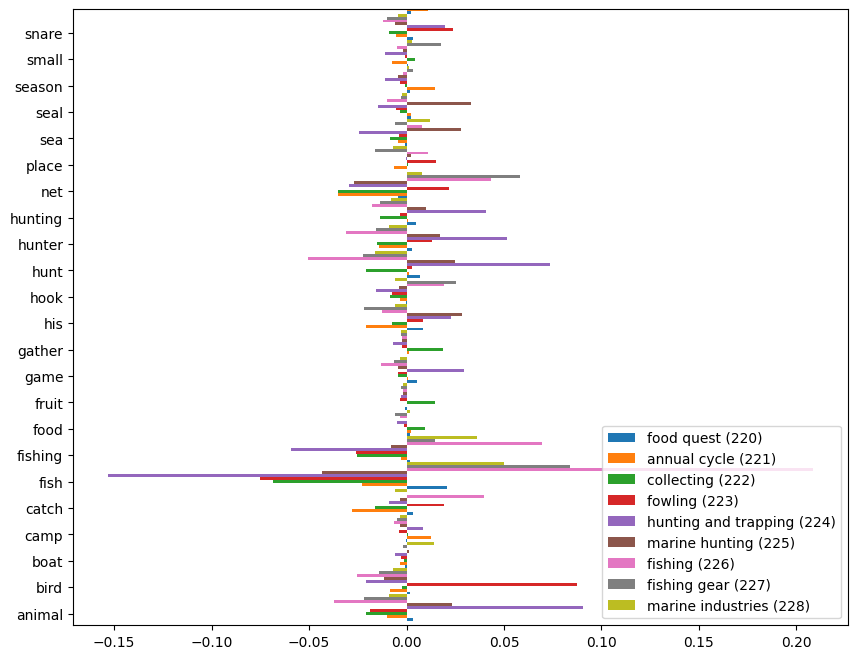

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7737003058103975
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.689     0.573     0.626       143
         222      0.781     0.724     0.751       123
         223      0.863     0.657     0.746       210
         224      0.785     0.938     0.855      1081
         225      0.849     0.669     0.749       118
         226      0.776     0.795     0.786       650
         227      0.576     0.369     0.450       206
         228      0.707     0.433     0.537        67

    accuracy                          0.774      2616
   macro avg      0.670     0.573     0.611      2616
weighted avg      0.763     0.774     0.761      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

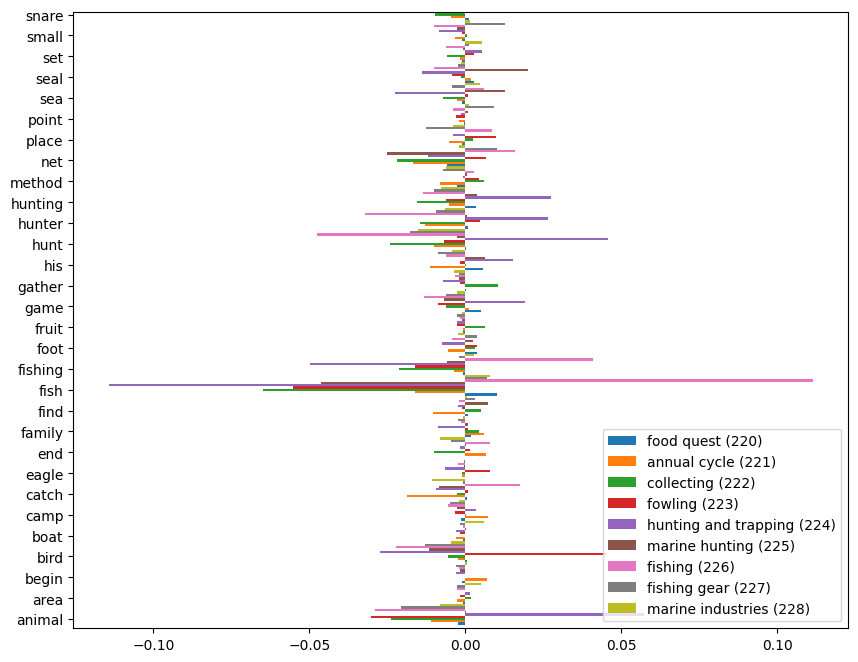

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7247706422018348
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.714     0.315     0.437       143
         222      0.820     0.593     0.689       123
         223      0.884     0.400     0.551       210
         224      0.716     0.961     0.820      1081
         225      0.923     0.407     0.565       118
         226      0.692     0.849     0.762       650
         227      0.797     0.228     0.355       206
         228      1.000     0.119     0.213        67

    accuracy                          0.725      2616
   macro avg      0.727     0.430     0.488      2616
weighted avg      0.746     0.725     0.688      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


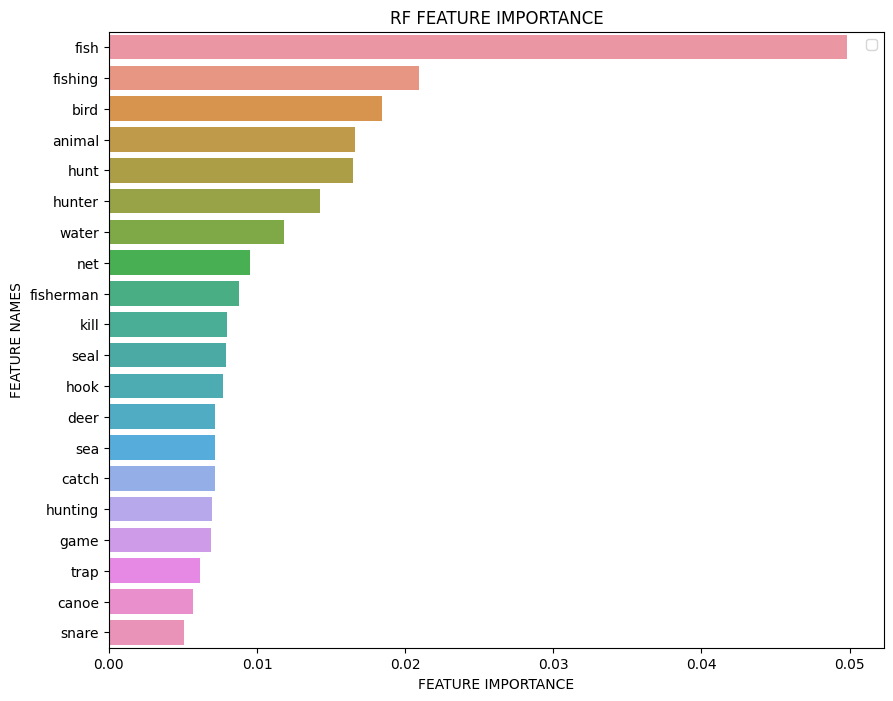

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 2
Exclude: {'wild', 'find', 'time', 'area', 'eagle', 'water', 'boat', 'place', 'hunting', 'seal', 'summer', 'method', 'animal', 'gather', 'his', 'family', 'net', 'season', 'set', 'fish', 'camp', 'their', 'snare', 'fishing', 'winter', 'hunter', 'trap', 'canoe', 'tree', 'deer', 'fisherman', 'point', 'catch', 'begin', 'game', 'hook', 'foot', 'sea', 'bird', 'small', 'hunt', 'whale', 'kill', 'fruit', 'end', 'turtle', 'food'}

(8717,) (8717,)
8717 documents - 3.86MB (training set)
9 categories


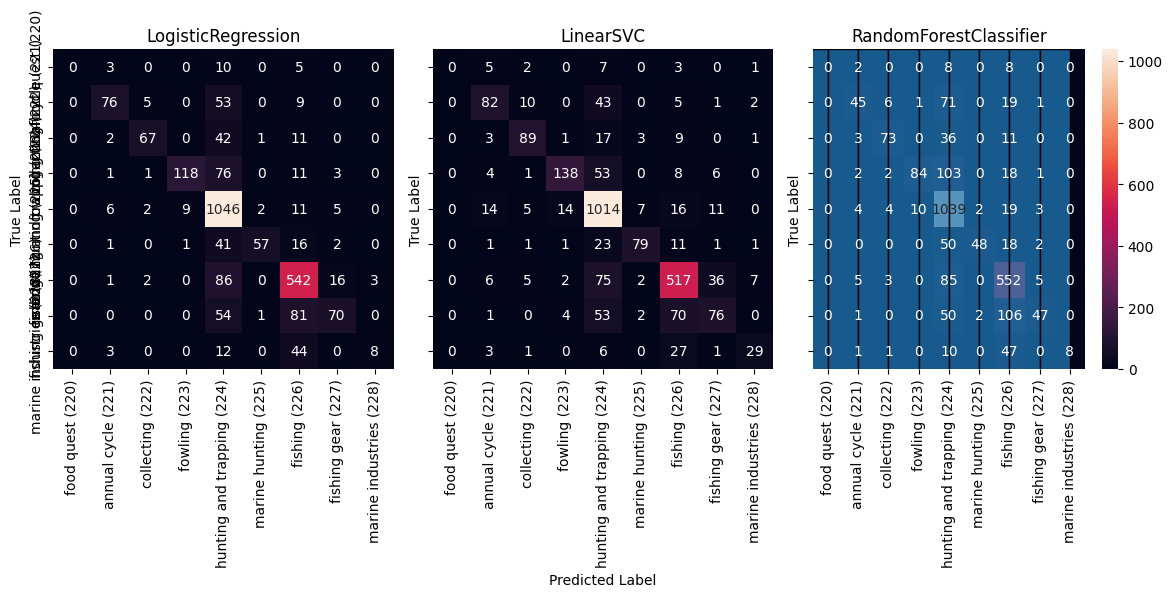

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6853975535168195
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.778     0.441     0.562       143
         222      0.898     0.431     0.582       123
         223      0.855     0.310     0.455       210
         224      0.675     0.951     0.789      1081
         225      0.909     0.169     0.286       118
         226      0.651     0.765     0.703       650
         227      0.725     0.282     0.406       206
         228      0.818     0.134     0.231        67

    accuracy                          0.685      2616
   macro avg      0.701     0.387     0.446      2616
weighted avg      0.713     0.685     0.646      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

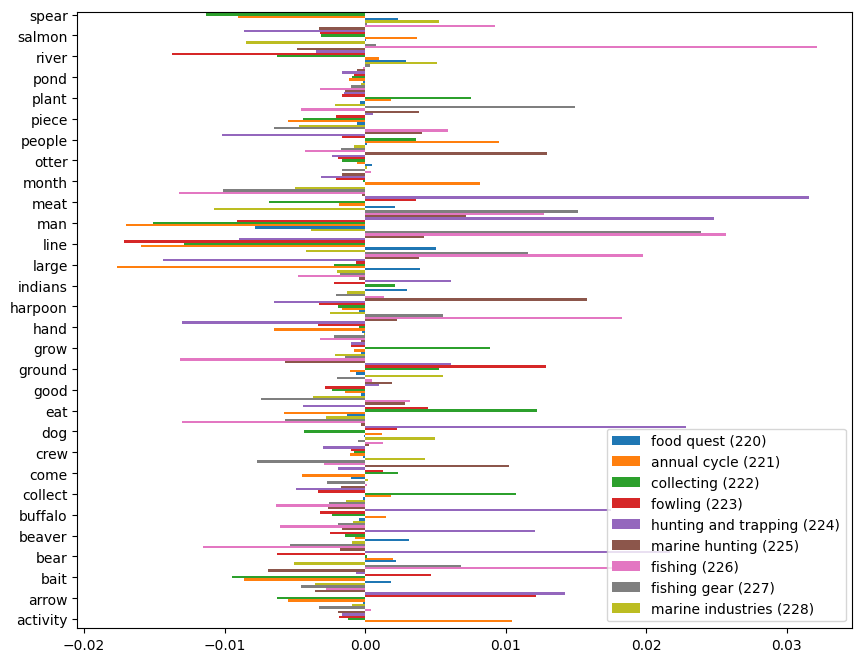

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7033639143730887
              precision    recall  f1-score   support

         220      1.000     0.056     0.105        18
         221      0.598     0.510     0.551       143
         222      0.745     0.593     0.661       123
         223      0.755     0.500     0.602       210
         224      0.731     0.908     0.810      1081
         225      0.690     0.415     0.519       118
         226      0.677     0.695     0.686       650
         227      0.575     0.354     0.438       206
         228      0.696     0.478     0.566        67

    accuracy                          0.703      2616
   macro avg      0.719     0.501     0.549      2616
weighted avg      0.700     0.703     0.688      2616



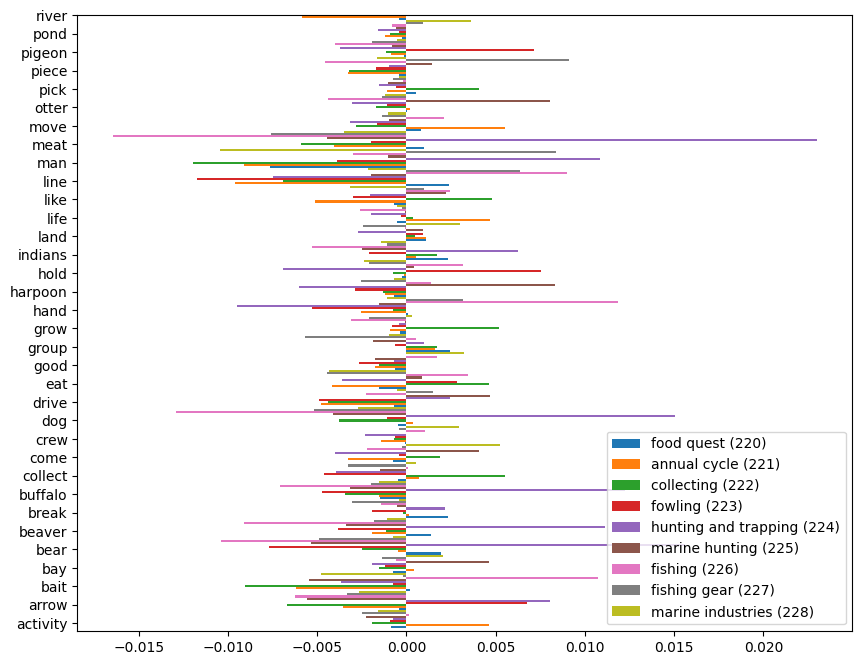

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6513761467889908
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.579     0.308     0.402       143
         222      0.684     0.439     0.535       123
         223      0.800     0.229     0.356       210
         224      0.674     0.920     0.778      1081
         225      0.778     0.119     0.206       118
         226      0.595     0.754     0.665       650
         227      0.710     0.214     0.328       206
         228      0.714     0.224     0.341        67

    accuracy                          0.651      2616
   macro avg      0.615     0.356     0.401      2616
weighted avg      0.664     0.651     0.606      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


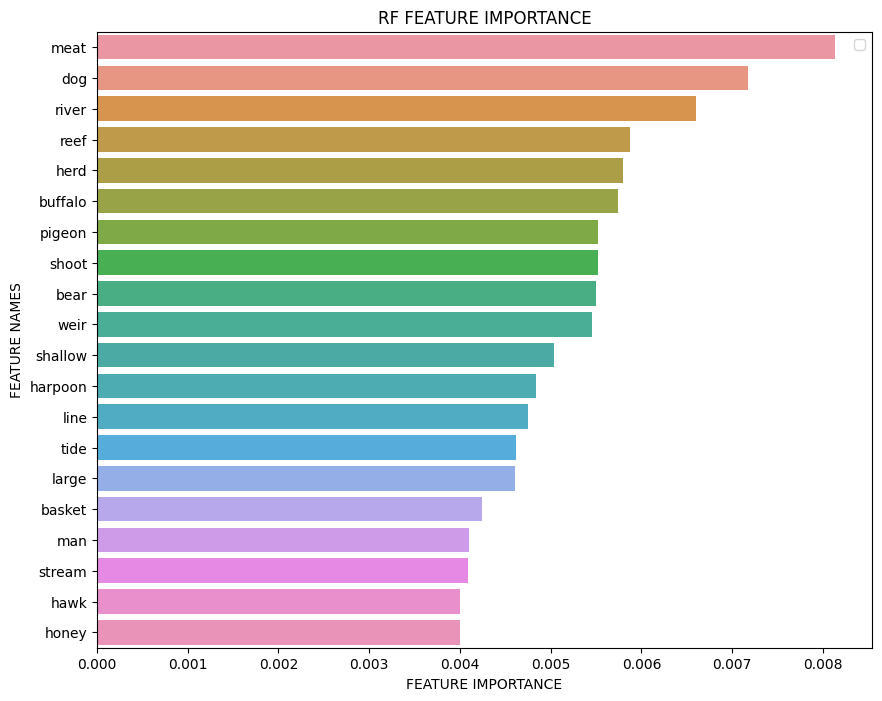

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Iteration 3
Exclude: {'river', 'line', 'stone', 'bay', 'use', 'tide', 'basket', 'time', 'salmon', 'herd', 'eagle', 'place', 'beaver', 'summer', 'large', 'method', 'land', 'harpoon', 'eat', 'pond', 'pigeon', 'animal', 'gather', 'village', 'set', 'break', 'piece', 'camp', 'bear', 'ground', 'like', 'snare', 'buffalo', 'winter', 'hunter', 'woman', 'trap', 'activity', 'deer', 'man', 'begin', 'arrow', 'shallow', 'people', 'year', 'shoot', 'foot', 'come', 'crew', 'spring', 'drive', 'hold', 'group', 'turtle', 'season', 'food', 'wild', 'area', 'meat', 'otter', 'water', 'indians', 'boat', 'hunting', 'seal', 'spear', 'his', 'honey', 'weir', 'family', 'net', 'bait', 'fish', 'life', 'their', 'reef', 'fishing', 'dog', 'canoe', 'hawk', 'tree', 'stick', 'fisherman', 'point', 'catch', 'game', 'hand', 'take', 'hook', 'grow', 'move', 'pick', 'sea', 'they', 'bird', 'small', 'collect', 'month', 'hunt', 'whale', 'kill', 'plant', 'fruit', 'end', 'good', 'usually', 'stream', 'find', 'shape'}

(8717,) (8717,)


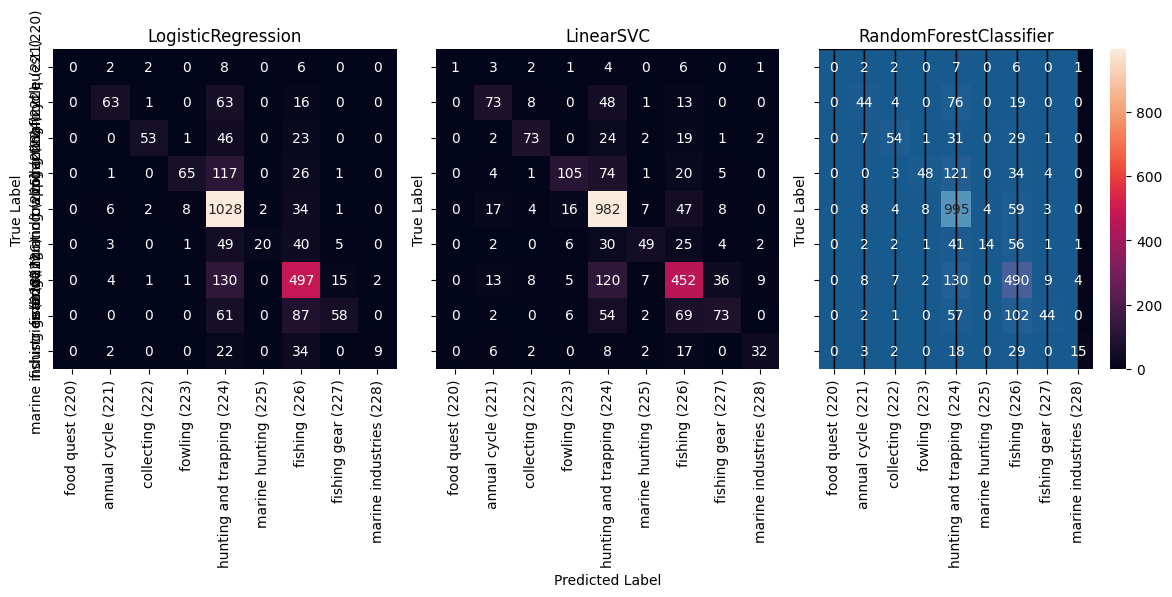

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6517584097859327
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.788     0.287     0.421       143
         222      0.830     0.317     0.459       123
         223      0.882     0.286     0.432       210
         224      0.645     0.948     0.768      1081
         225      1.000     0.068     0.127       118
         226      0.611     0.714     0.659       650
         227      0.714     0.291     0.414       206
         228      0.889     0.119     0.211        67

    accuracy                          0.652      2616
   macro avg      0.707     0.337     0.388      2616
weighted avg      0.696     0.652     0.604      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

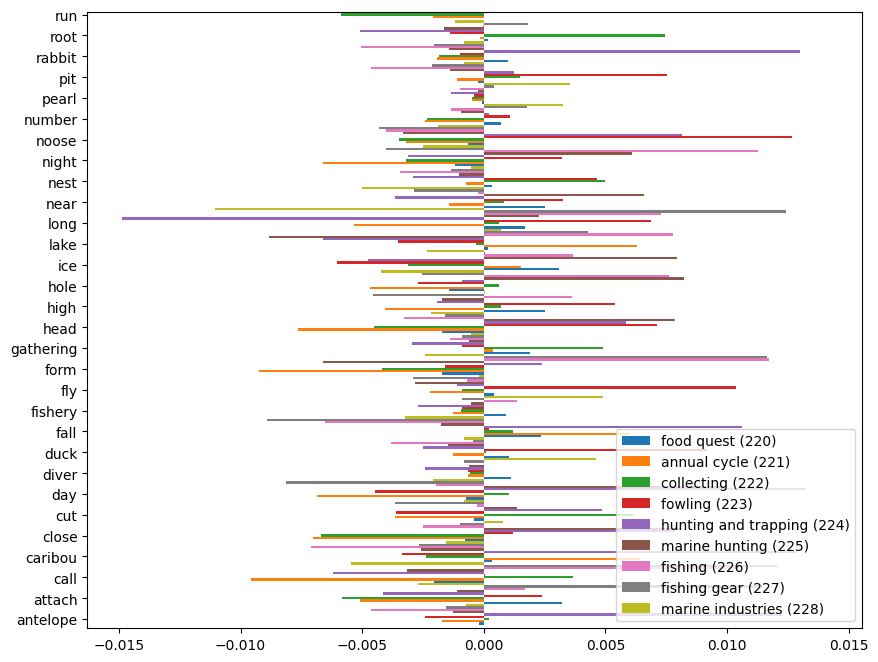

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.672782874617737
              precision    recall  f1-score   support

         220      0.500     0.056     0.100        18
         221      0.575     0.427     0.490       143
         222      0.656     0.496     0.565       123
         223      0.716     0.457     0.558       210
         224      0.701     0.893     0.786      1081
         225      0.709     0.331     0.451       118
         226      0.642     0.655     0.648       650
         227      0.586     0.398     0.474       206
         228      0.630     0.433     0.513        67

    accuracy                          0.673      2616
   macro avg      0.635     0.461     0.509      2616
weighted avg      0.667     0.673     0.655      2616



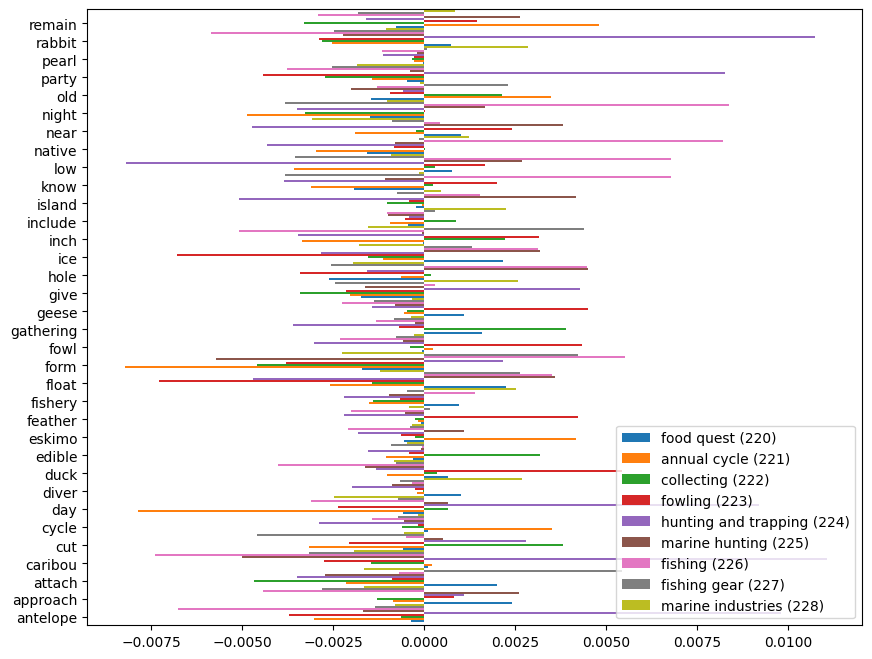

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.621177370030581
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.596     0.217     0.318       143
         222      0.667     0.358     0.466       123
         223      0.829     0.300     0.441       210
         224      0.642     0.920     0.756      1081
         225      0.800     0.034     0.065       118
         226      0.555     0.682     0.612       650
         227      0.623     0.160     0.255       206
         228      0.722     0.194     0.306        67

    accuracy                          0.621      2616
   macro avg      0.604     0.318     0.358      2616
weighted avg      0.637     0.621     0.570      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


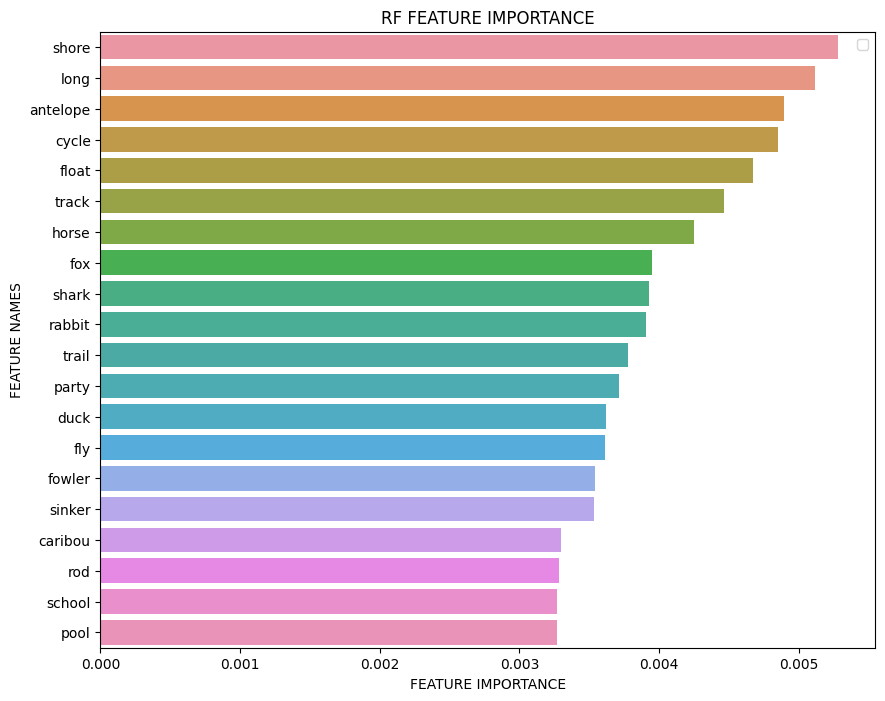

C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:52: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



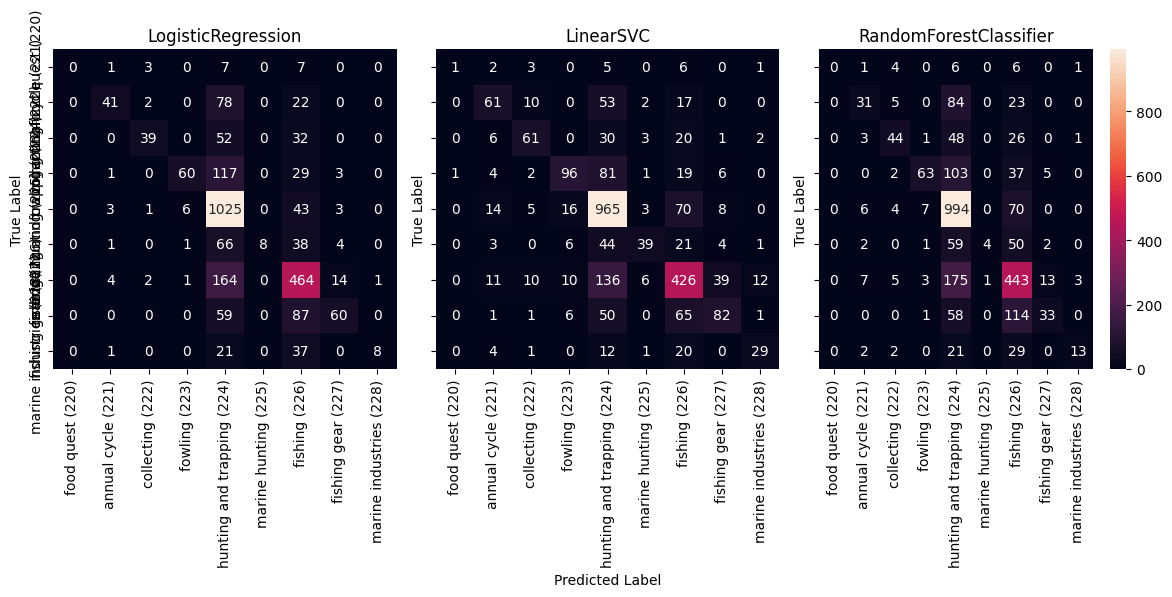

In [21]:
results = defaultdict(dict)
for b in [True, False]:
    print('\n\nBalanced:', b)
    for i in [220]:#, 240]:
        curr_results = iterative_process(common_indicators=False,
                                    models=['LR', 'SVM', 'RF'], 
                                    specific_cat=i, exact=False, 
                                    id=f'3 ({i})',
                                    df_performance=df_performance,
                                    balanced=b,
                                    verbose=True)
        results[f'{i}_{"balanced" if b else "imbalanced"}'] = curr_results
        

In [22]:

for b in [True, False]:
    print('\n\nBalanced:', b)
    for i in [220]:#, 240]:for i in [220]:#, 240]:
        plot_performance(results[f'{i}_{"balanced" if b else "imbalanced"}'], fig_path=f'output/metric/{i}_{"balanced" if b else "imbalanced"}.png')



Balanced: True




Balanced: False


In [23]:
df_performance = df_performance.round(2)


In [24]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
\midrule
1 (224, 226)\_LR  &       0.95 &    0.92 &      0.93 \\
1 (224, 226)\_SVM &       0.95 &    0.93 &      0.93 \\
1 (224, 226)\_RF  &       0.94 &    0.92 &      0.93 \\
1 (221..226)\_LR  &       0.82 &    0.78 &      0.79 \\
1 (221..226)\_SVM &       0.80 &    0.77 &      0.78 \\
1 (221..226)\_RF  &       0.79 &    0.75 &      0.76 \\
2 (224)\_LR       &       0.89 &    0.88 &      0.88 \\
2 (224)\_SVM      &       0.89 &    0.88 &      0.88 \\
2 (224)\_RF       &       0.88 &    0.86 &      0.87 \\
2 (226)\_LR       &       0.86 &    0.80 &      0.82 \\
2 (226)\_SVM      &       0.86 &    0.83 &      0.84 \\
2 (226)\_RF       &       0.86 &    0.84 &      0.85 \\
3 (220)\_LR       &       0.72 &    0.49 &      0.55 \\
3 (220)\_SVM      &       0.67 &    0.57 &      0.61 \\
3 (220)\_RF       &       0.73 &    0.43 &      0.49 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_13264\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [25]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
\midrule
1 (224, 226)\_LR  &       0.95 &    0.92 &      0.93 \\
1 (224, 226)\_SVM &       0.95 &    0.93 &      0.93 \\
1 (224, 226)\_RF  &       0.94 &    0.92 &      0.93 \\
1 (221..226)\_LR  &       0.82 &    0.78 &      0.79 \\
1 (221..226)\_SVM &       0.80 &    0.77 &      0.78 \\
1 (221..226)\_RF  &       0.79 &    0.75 &      0.76 \\
2 (224)\_LR       &       0.89 &    0.88 &      0.88 \\
2 (224)\_SVM      &       0.89 &    0.88 &      0.88 \\
2 (224)\_RF       &       0.88 &    0.86 &      0.87 \\
2 (226)\_LR       &       0.86 &    0.80 &      0.82 \\
2 (226)\_SVM      &       0.86 &    0.83 &      0.84 \\
2 (226)\_RF       &       0.86 &    0.84 &      0.85 \\
3 (220)\_LR       &       0.72 &    0.49 &      0.55 \\
3 (220)\_SVM      &       0.67 &    0.57 &      0.61 \\
3 (220)\_RF       &       0.73 &    0.43 &      0.49 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_13264\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



- categorize features for each culture
- measure the sim between cultures based on these categories?
- this would allow comparing cultures based on the sim of these features across cultures based on some threshold (e.g. tfidf)
- they indicate the levels/types of the usage/facts of these cultures;
    - e.g. one culture is more advanced in using tools
    - e.g. en